In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from chart_studio.plotly import plot_mpl
import math
matplotlib.rcParams.update({'font.size': 22})

In [3]:
# Clipping data to our needs
def data(range_):
    precipitation = pd.read_csv('monthwise_datasets/Monthwise_Precipitation.csv')
    sunspot = pd.read_csv('monthwise_datasets/Monthwise_Sunspot.csv')

    sunspot['Date']= pd.to_datetime(sunspot['Date'])
    precipitation['Date']= pd.to_datetime(precipitation['Date'])

    sunspot.set_index('Date', inplace=True)
    precipitation.set_index('Date', inplace=True)

    sunspot = sunspot[range_[0]:range_[1]] #['1951-01-01': '2017-01-01']

    sunspot['year'] = pd.DatetimeIndex(sunspot.index).year
    precipitation['year'] = pd.DatetimeIndex(precipitation.index).year

    sunspot['month'] = pd.DatetimeIndex(sunspot.index).month
    precipitation['month'] = pd.DatetimeIndex(precipitation.index).month

    precipitation = precipitation.asfreq('M', method='bfill')
    sunspot = sunspot.asfreq('M', method='bfill')
    
    return precipitation, sunspot

In [4]:
precipitation, sunspot = data(['1951-01-01', '2017-01-01'])

## ACF and PACF for precipitation data

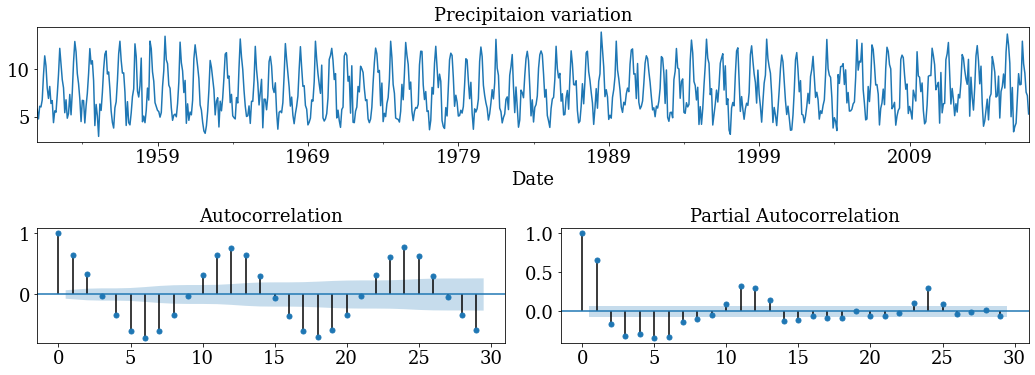

In [9]:
y1=precipitation['Precipitation']

figsize=(22,8)
fig = plt.figure()
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 3), (1, 0))
ax3 = plt.subplot2grid((3, 3), (1, 1))

y1.plot(ax=ax1, figsize=figsize)
ax1.set_title('Precipitaion variation')

plot_acf(y1,  ax=ax2, alpha=.05);

plot_pacf(y1,  ax=ax3, alpha=.05);
plt.savefig('Precip.png')
plt.tight_layout()

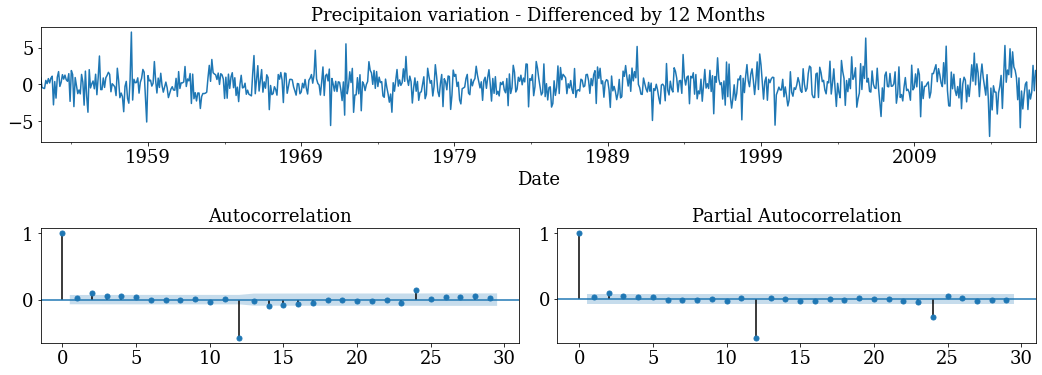

In [20]:
y2=precipitation['Precipitation'].diff(12).dropna()

figsize=(22,8)
fig = plt.figure()
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 3), (1, 0))
ax3 = plt.subplot2grid((3, 3), (1, 1))

y2.plot(ax=ax1, figsize=figsize)
ax1.set_title('Precipitaion variation - Differenced by 12 Months')

plot_acf(y2,  ax=ax2, alpha=.05);

plot_pacf(y2,  ax=ax3, alpha=.05);
plt.savefig('Precip_12diff.png')
plt.tight_layout()

## ARMA/ARMAX

In [11]:
## Function to calculate Root Mean Square Error
def measure_rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true,y_pred))

In [12]:
def walk_forward(training_set, test_set, params, exog_train=[], exog_forecast=[]):
    
    history = [x for x in training_set.values]
    
    ## ((p,d,q),(P,D,Q,S)) params can be passed to the model 
    pdq, PDQS = params

    ## SARIMAX model is used which returns aic and bic values
    if len(exog_train)!=0:
        model = sm.tsa.statespace.SARIMAX(history, exog = exog_train, order=pdq, seasonal_order=PDQS)
    else:
        model = sm.tsa.statespace.SARIMAX(history, order = pdq, seasonal_order=PDQS)
        
    result = model.fit(disp=False,maxiter=200)
    aic = result.aic
    bic = result.bic

    print("MLE vals",(result.mle_retvals))
    
    if len(exog_forecast)!=0:
        yhat = result.predict(start=len(history), end=len(history)+len(test_set)-1, exog = exog_forecast, dynamic= True)
    else:
        yhat = result.predict(start=len(history), end=len(history)+len(test_set)-1)
    
    return yhat , aic, bic

In [13]:
def grid_search(train, test, exog_train=[], exog_forecast=[]):

    S = 12
    min_rmse = 5000
    ## Varying the values of p,d,q,P,D,Q in the vicinity of respective observed values
    for p in [0,1,2]:
        for q in [0,1,2]:
            for d in [0,1]:
                for P in [0,1,2]:
                    for Q in [0,1,2]:
                        for D in [0,1]:
                            try:
                                params = ((p,d,q),(P,D,Q,S))

                                ## Train the model for these params
                                if len(exog_train)!=0:
                                    yhat,aic,bic = walk_forward(train, test, params, exog_train, exog_forecast)

                                else:
                                    yhat,aic,bic = walk_forward(train, test, params)

                                rmse_ = measure_rmse(test,yhat)

                                ## Find the minimum rmse among all the combinations of params
                                if rmse_< min_rmse:
                                    min_rmse=rmse_
                                    min_params = params
                                    min_aic = aic
                                    min_bic=bic

                                print("Params:", params, ", RMSE:",round(rmse_,2),", AIC:", round(aic,2),", BIC:",round(bic,2) )
                            except:
                                print('Fail')
    print("==================================================================\n")                          
    print("Best param values are : ((p,d,q),(P,D,Q,S)) : ",min_params)
    print("RMSE : ",min_rmse,"\nAIC : ", min_aic,"\nBIC : ",min_bic)

    return min_params, min_rmse, min_aic, min_bic

# GridSearch

In [31]:
min_params, min_rmse, min_aic, min_bic = grid_search(train['Precipitation'], test['Precipitation'])

MLE vals {'fopt': 3.5185000890245006, 'gopt': array([1.50146562e-07]), 'fcalls': 2, 'warnflag': 0, 'converged': True, 'iterations': 0}
Params: ((0, 0, 0), (0, 0, 0, 12)) , RMSE: 8.7 , AIC: 5012.34 , BIC: 5016.91
MLE vals {'fopt': 1.8615611069264772, 'gopt': array([-5.7556182e-07]), 'fcalls': 10, 'warnflag': 0, 'converged': True, 'iterations': 3}
Params: ((0, 0, 0), (0, 1, 0, 12)) , RMSE: 2.08 , AIC: 2652.86 , BIC: 2657.41
MLE vals {'fopt': 3.030904319023881, 'gopt': array([4.23261426e-07, 1.18483001e-07]), 'fcalls': 42, 'warnflag': 0, 'converged': True, 'iterations': 10}
Params: ((0, 0, 0), (0, 0, 1, 12)) , RMSE: 8.3 , AIC: 4320.01 , BIC: 4329.14
MLE vals {'fopt': 1.537640090544019, 'gopt': array([ 2.19624319e-07, -4.79618567e-06]), 'fcalls': 42, 'warnflag': 0, 'converged': True, 'iterations': 11}
Params: ((0, 0, 0), (0, 1, 1, 12)) , RMSE: 1.58 , AIC: 2193.6 , BIC: 2202.7
MLE vals {'fopt': 2.6966963375563755, 'gopt': array([ 7.10849157e-06,  3.60191876e-06, -7.16129378e-06]), 'fcalls':

MLE vals {'fopt': 1.8579332085987887, 'gopt': array([-4.54170035e-07, -3.03232994e-06, -1.33000277e-06,  1.29645183e-06,
       -3.83006959e-06]), 'fcalls': 234, 'warnflag': 0, 'converged': True, 'iterations': 30}
Params: ((0, 1, 0), (2, 0, 2, 12)) , RMSE: 2.92 , AIC: 2655.7 , BIC: 2678.53
MLE vals {'fopt': 1.8280420343241346, 'gopt': array([-9.27258270e-08, -3.91353616e-07, -2.11830553e-08, -3.40150130e-07,
        6.76125822e-08]), 'fcalls': 180, 'warnflag': 0, 'converged': True, 'iterations': 25}
Params: ((0, 1, 0), (2, 1, 2, 12)) , RMSE: 2.9 , AIC: 2613.13 , BIC: 2635.88
MLE vals {'fopt': 2.993777573890021, 'gopt': array([-1.73905335e-07, -2.92388336e-07]), 'fcalls': 42, 'warnflag': 0, 'converged': True, 'iterations': 7}
Params: ((0, 0, 1), (0, 0, 0, 12)) , RMSE: 8.66 , AIC: 4267.14 , BIC: 4276.28
MLE vals {'fopt': 1.8615308017395347, 'gopt': array([ 4.43289849e-07, -1.84741111e-07]), 'fcalls': 18, 'warnflag': 0, 'converged': True, 'iterations': 3}
Params: ((0, 0, 1), (0, 1, 0, 12)

/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MLE vals {'fopt': 1.578861035854303, 'gopt': array([-0.14344745, -0.08458885, -0.05217422,  0.20403266]), 'fcalls': 690, 'warnflag': 2, 'converged': False, 'iterations': 25}
Params: ((0, 1, 1), (1, 0, 1, 12)) , RMSE: 1.57 , AIC: 2256.3 , BIC: 2274.56
MLE vals {'fopt': 1.5403880273054542, 'gopt': array([-7.39408534e-09, -2.48179255e-07, -3.31512595e-08,  4.39492887e-07]), 'fcalls': 150, 'warnflag': 0, 'converged': True, 'iterations': 24}
Params: ((0, 1, 1), (1, 1, 1, 12)) , RMSE: 1.56 , AIC: 2201.51 , BIC: 2219.71
Fail
MLE vals {'fopt': 1.537310152464452, 'gopt': array([ 1.49680268e-07,  3.06015213e-06, -5.51336754e-07,  2.50803822e-06,
       -6.41708908e-08]), 'fcalls': 168, 'warnflag': 0, 'converged': True, 'iterations': 23}
Params: ((0, 1, 1), (1, 1, 2, 12)) , RMSE: 1.56 , AIC: 2199.13 , BIC: 2221.88
MLE vals {'fopt': 1.702534916576552, 'gopt': array([ 1.57118762e-07, -6.53697096e-06,  5.73437076e-05, -3.98849176e-05]), 'fcalls': 245, 'warnflag': 0, 'converged': True, 'iterations': 

/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.8606175720414422, 'gopt': array([-7.08582082e-06, -1.43997481e-05, -4.72049066e-06]), 'fcalls': 24, 'warnflag': 0, 'converged': True, 'iterations': 3}
Params: ((0, 0, 2), (0, 1, 0, 12)) , RMSE: 2.07 , AIC: 2655.52 , BIC: 2669.17
MLE vals {'fopt': 2.5124028212088474, 'gopt': array([-1.41255896e-06, -1.37609923e-06, -5.58664226e-07,  4.57500704e-07]), 'fcalls': 100, 'warnflag': 0, 'converged': True, 'iterations': 12}
Params: ((0, 0, 2), (0, 0, 1, 12)) , RMSE: 8.28 , AIC: 3585.66 , BIC: 3603.93
MLE vals {'fopt': 1.533939660576, 'gopt': array([-2.39364084e-06, -4.21451762e-06,  3.15769633e-07,  2.50088839e-06]), 'fcalls': 95, 'warnflag': 0, 'converged': True, 'iterations': 14}
Params: ((0, 0, 2), (0, 1, 1, 12)) , RMSE: 1.58 , AIC: 2192.33 , BIC: 2210.53


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 2.3342706219774714, 'gopt': array([1.47826640e-05, 1.45554679e-06, 3.27369243e-06, 9.98343630e-06,
       2.56568100e-06]), 'fcalls': 126, 'warnflag': 0, 'converged': True, 'iterations': 13}
Params: ((0, 0, 2), (0, 0, 2, 12)) , RMSE: 7.89 , AIC: 3334.0 , BIC: 3356.84
MLE vals {'fopt': 1.5318191849375447, 'gopt': array([-5.00017805e-06,  1.76522574e-05, -7.86704035e-08,  1.44786405e-06,
        3.64210884e-06]), 'fcalls': 96, 'warnflag': 0, 'converged': True, 'iterations': 13}
Params: ((0, 0, 2), (0, 1, 2, 12)) , RMSE: 1.58 , AIC: 2191.31 , BIC: 2214.07


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.9130431646319574, 'gopt': array([ 1.03914655e-06, -4.58455496e-07,  3.38218342e-07,  1.78450588e-06]), 'fcalls': 120, 'warnflag': 0, 'converged': True, 'iterations': 12}
Params: ((0, 0, 2), (1, 0, 0, 12)) , RMSE: 2.36 , AIC: 2732.17 , BIC: 2750.45
MLE vals {'fopt': 1.6793565819241953, 'gopt': array([ 3.61742192e-05,  1.95074179e-05, -2.45916620e-06, -2.95960367e-05]), 'fcalls': 40, 'warnflag': 0, 'converged': True, 'iterations': 6}
Params: ((0, 0, 2), (1, 1, 0, 12)) , RMSE: 1.82 , AIC: 2399.4 , BIC: 2417.61


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.5957433429142147, 'gopt': array([-0.02018278,  0.00043894, -0.00011152,  0.00111259,  0.01376847]), 'fcalls': 330, 'warnflag': 0, 'converged': True, 'iterations': 25}
Params: ((0, 0, 2), (1, 0, 1, 12)) , RMSE: 1.6 , AIC: 2282.34 , BIC: 2305.18
MLE vals {'fopt': 1.531513550256416, 'gopt': array([ 3.94484445e-06,  2.23288055e-06,  6.69468925e-06, -2.14095408e-07,
        1.15839560e-05]), 'fcalls': 114, 'warnflag': 0, 'converged': True, 'iterations': 14}
Params: ((0, 0, 2), (1, 1, 1, 12)) , RMSE: 1.58 , AIC: 2190.88 , BIC: 2213.63


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.5920786794358426, 'gopt': array([-8.67636154e-03,  5.81565907e-06,  3.33077077e-04, -5.63795144e-04,
       -3.72023048e-03, -1.85791604e-05]), 'fcalls': 511, 'warnflag': 0, 'converged': True, 'iterations': 38}
Params: ((0, 0, 2), (1, 0, 2, 12)) , RMSE: 1.6 , AIC: 2279.12 , BIC: 2306.53
MLE vals {'fopt': 1.5280621182819092, 'gopt': array([-2.50044430e-07,  2.12152518e-06,  7.83595411e-08, -1.62447833e-07,
       -1.23767663e-07,  8.43458636e-07]), 'fcalls': 203, 'warnflag': 0, 'converged': True, 'iterations': 23}
Params: ((0, 0, 2), (1, 1, 2, 12)) , RMSE: 1.58 , AIC: 2187.96 , BIC: 2215.27


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.7345495081673903, 'gopt': array([ 8.66640093e-08,  7.19801996e-07,  7.58060281e-08, -9.00368669e-07,
        4.93582952e-07]), 'fcalls': 192, 'warnflag': 0, 'converged': True, 'iterations': 20}
Params: ((0, 0, 2), (2, 0, 0, 12)) , RMSE: 1.9 , AIC: 2480.0 , BIC: 2502.84
MLE vals {'fopt': 1.6342830114065945, 'gopt': array([-1.43838275e-06, -1.11188836e-06,  8.77320439e-07, -1.18425270e-06,
       -3.21986882e-07]), 'fcalls': 48, 'warnflag': 0, 'converged': True, 'iterations': 5}
Params: ((0, 0, 2), (2, 1, 0, 12)) , RMSE: 1.73 , AIC: 2337.22 , BIC: 2359.97


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.5914701536465163, 'gopt': array([-0.02407724,  0.00010815, -0.00039709,  0.004977  , -0.00511107,
       -0.00978668]), 'fcalls': 427, 'warnflag': 0, 'converged': True, 'iterations': 25}
Params: ((0, 0, 2), (2, 0, 1, 12)) , RMSE: 1.6 , AIC: 2278.25 , BIC: 2305.66
MLE vals {'fopt': 1.5296297845880575, 'gopt': array([-5.62661029e-08,  4.94120300e-06,  2.41568987e-06,  4.00537381e-06,
       -6.33715302e-08, -1.62501124e-06]), 'fcalls': 140, 'warnflag': 0, 'converged': True, 'iterations': 16}
Params: ((0, 0, 2), (2, 1, 1, 12)) , RMSE: 1.58 , AIC: 2190.19 , BIC: 2217.5


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.587968986947668, 'gopt': array([0.00429094, 0.00708313, 0.000628  , 0.00059621, 0.00094868,
       0.00065738, 0.00307976]), 'fcalls': 632, 'warnflag': 0, 'converged': True, 'iterations': 46}
Params: ((0, 0, 2), (2, 0, 2, 12)) , RMSE: 1.59 , AIC: 2275.27 , BIC: 2307.24
MLE vals {'fopt': 1.5280364934750308, 'gopt': array([-7.57791607e-06, -7.94517785e-06, -9.34301525e-06,  3.88589161e-06,
        2.49260612e-06, -1.26553212e-05, -4.18434176e-06]), 'fcalls': 232, 'warnflag': 0, 'converged': True, 'iterations': 23}
Params: ((0, 0, 2), (2, 1, 2, 12)) , RMSE: 1.58 , AIC: 2189.92 , BIC: 2221.78
MLE vals {'fopt': 2.1299305847978847, 'gopt': array([ 9.86570825e-06, -9.18465304e-07,  9.45332701e-07]), 'fcalls': 28, 'warnflag': 0, 'converged': True, 'iterations': 5}
Params: ((0, 1, 2), (0, 0, 0, 12)) , RMSE: 2.79 , AIC: 3039.02 , BIC: 3052.72
MLE vals {'fopt': 1.864205698782225, 'gopt': array([ 3.20590221e-06, -1.86730631e-06,  2.13884466e-06]), 'fcalls': 100, 'warnflag': 0, 

/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MLE vals {'fopt': 1.5757345181209164, 'gopt': array([-0.00221296, -0.00245558, -0.00204061,  0.0011872 , -0.0030964 ,
        0.00246473]), 'fcalls': 959, 'warnflag': 2, 'converged': False, 'iterations': 46}
Params: ((0, 1, 2), (2, 0, 1, 12)) , RMSE: 1.59 , AIC: 2255.85 , BIC: 2283.25
MLE vals {'fopt': 1.5371587227520465, 'gopt': array([ 1.37245770e-07,  5.50193224e-06, -1.51458845e-06, -6.02882189e-06,
        1.02140518e-09,  9.25082233e-07]), 'fcalls': 455, 'warnflag': 0, 'converged': True, 'iterations': 45}
Params: ((0, 1, 2), (2, 1, 1, 12)) , RMSE: 1.56 , AIC: 2200.91 , BIC: 2228.21
MLE vals {'fopt': 1.5711939797992696, 'gopt': array([ 2.52316057e-04, -5.77261861e-04, -1.07019731e-03, -4.51788607e-05,
       -1.81692121e-03, -1.71525727e-04, -6.25155172e-04]), 'fcalls': 928, 'warnflag': 0, 'converged': True, 'iterations': 68}
Params: ((0, 1, 2), (2, 0, 2, 12)) , RMSE: 1.57 , AIC: 2251.38 , BIC: 2283.35
MLE vals {'fopt': 1.5354364286191973, 'gopt': array([ 7.37188088e-08,  4.060396

MLE vals {'fopt': 1.7299503350859458, 'gopt': array([ 1.92212668e-04,  4.75508521e-06, -3.56885632e-05, -1.47624934e-04,
       -5.37964007e-04]), 'fcalls': 240, 'warnflag': 0, 'converged': True, 'iterations': 26}
Params: ((1, 1, 0), (1, 0, 2, 12)) , RMSE: 2.33 , AIC: 2473.45 , BIC: 2496.28
MLE vals {'fopt': 1.690605509002966, 'gopt': array([ 3.46687123e-06,  1.84403603e-06,  6.23967544e-07, -1.53317359e-06,
       -1.16674448e-05]), 'fcalls': 156, 'warnflag': 0, 'converged': True, 'iterations': 19}
Params: ((1, 1, 0), (1, 1, 2, 12)) , RMSE: 2.41 , AIC: 2417.42 , BIC: 2440.17
MLE vals {'fopt': 1.8525529489858514, 'gopt': array([-4.08331147e-06, -3.27657901e-06, -6.32283115e-06,  5.80260284e-06]), 'fcalls': 65, 'warnflag': 0, 'converged': True, 'iterations': 11}
Params: ((1, 1, 0), (2, 0, 0, 12)) , RMSE: 4.3 , AIC: 2646.04 , BIC: 2664.3
MLE vals {'fopt': 1.806055122271519, 'gopt': array([1.49857904e-07, 8.20499224e-07, 2.76845213e-07, 3.13571391e-07]), 'fcalls': 45, 'warnflag': 0, 'conv

/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.8641855133502876, 'gopt': array([-1.05152331e-05,  4.00923739e-07, -2.19247509e-05]), 'fcalls': 116, 'warnflag': 0, 'converged': True, 'iterations': 24}
Params: ((1, 1, 1), (0, 1, 0, 12)) , RMSE: 2.08 , AIC: 2660.6 , BIC: 2674.25


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 2.075998768625422, 'gopt': array([-1.98099315e-06,  2.66151545e-06,  3.98032718e-06,  1.40851775e-06]), 'fcalls': 75, 'warnflag': 0, 'converged': True, 'iterations': 13}
Params: ((1, 1, 1), (0, 0, 1, 12)) , RMSE: 2.58 , AIC: 2964.22 , BIC: 2982.49
MLE vals {'fopt': 1.5410187414372551, 'gopt': array([3.26488170e-05, 2.04636308e-07, 2.31059616e-06, 2.80541146e-05]), 'fcalls': 165, 'warnflag': 0, 'converged': True, 'iterations': 28}
Params: ((1, 1, 1), (0, 1, 1, 12)) , RMSE: 1.56 , AIC: 2202.41 , BIC: 2220.61


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.8869575482196614, 'gopt': array([-1.26325173e-05,  1.49436019e-08,  3.70401265e-05,  5.53150858e-06,
       -1.35764733e-05]), 'fcalls': 336, 'warnflag': 0, 'converged': True, 'iterations': 43}
Params: ((1, 1, 1), (0, 0, 2, 12)) , RMSE: 2.48 , AIC: 2697.03 , BIC: 2719.86
MLE vals {'fopt': 1.539009032555079, 'gopt': array([ 9.87787629e-06, -4.47797355e-07, -2.46025422e-07,  3.77555764e-06,
        2.18983276e-05]), 'fcalls': 168, 'warnflag': 0, 'converged': True, 'iterations': 23}
Params: ((1, 1, 1), (0, 1, 2, 12)) , RMSE: 1.56 , AIC: 2201.55 , BIC: 2224.3


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.8415449036157552, 'gopt': array([-1.73705939e-05,  3.53050922e-09, -1.08519416e-05,  2.91935809e-05]), 'fcalls': 225, 'warnflag': 0, 'converged': True, 'iterations': 40}
Params: ((1, 1, 1), (1, 0, 0, 12)) , RMSE: 2.24 , AIC: 2630.36 , BIC: 2648.63
MLE vals {'fopt': 1.6846066780815594, 'gopt': array([-1.18522969e-05,  2.44249065e-10,  9.73334524e-05, -1.53211488e-04]), 'fcalls': 235, 'warnflag': 0, 'converged': True, 'iterations': 36}
Params: ((1, 1, 1), (1, 1, 0, 12)) , RMSE: 1.82 , AIC: 2406.88 , BIC: 2425.08


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fail
MLE vals {'fopt': 1.538718357755788, 'gopt': array([-1.10252252e-05,  1.10755849e-07, -2.13564499e-05,  4.95625763e-07,
       -2.48303600e-06]), 'fcalls': 276, 'warnflag': 0, 'converged': True, 'iterations': 36}
Params: ((1, 1, 1), (1, 1, 1, 12)) , RMSE: 1.56 , AIC: 2201.13 , BIC: 2223.88


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.5756917673955202, 'gopt': array([-1.88834706e-03, -3.98244615e-04, -4.59505789e-04, -2.69872968e-04,
       -3.87391230e-05,  4.51763249e-04]), 'fcalls': 476, 'warnflag': 0, 'converged': True, 'iterations': 25}
Params: ((1, 1, 1), (1, 0, 2, 12)) , RMSE: 1.59 , AIC: 2255.79 , BIC: 2283.19
MLE vals {'fopt': 1.535193566851221, 'gopt': array([ 1.23322907e-05, -1.13353771e-07,  8.23601187e-06, -2.26278996e-06,
        1.37636347e-05,  4.09641210e-05]), 'fcalls': 427, 'warnflag': 0, 'converged': True, 'iterations': 45}
Params: ((1, 1, 1), (1, 1, 2, 12)) , RMSE: 1.56 , AIC: 2198.12 , BIC: 2225.41


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.6989055466666354, 'gopt': array([-3.60884211e-05,  1.28053124e-07, -3.69309028e-06, -2.01533013e-05,
       -2.81975332e-05]), 'fcalls': 366, 'warnflag': 0, 'converged': True, 'iterations': 41}
Params: ((1, 1, 1), (2, 0, 0, 12)) , RMSE: 1.89 , AIC: 2429.24 , BIC: 2452.07
MLE vals {'fopt': 1.639376668750257, 'gopt': array([ 7.79709630e-07, -8.88178419e-11,  7.12829795e-07,  2.37159181e-06,
        2.29756214e-06]), 'fcalls': 288, 'warnflag': 0, 'converged': True, 'iterations': 38}
Params: ((1, 1, 1), (2, 1, 0, 12)) , RMSE: 1.73 , AIC: 2344.47 , BIC: 2367.22


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.574984706922737, 'gopt': array([-0.01760256,  0.03051329,  0.01933984,  0.02383527,  0.01470915,
        0.03766281]), 'fcalls': 217, 'warnflag': 0, 'converged': True, 'iterations': 18}
Params: ((1, 1, 1), (2, 0, 1, 12)) , RMSE: 1.58 , AIC: 2254.78 , BIC: 2282.18
MLE vals {'fopt': 1.5368825042290652, 'gopt': array([-4.93025620e-06,  7.34967642e-08,  2.94941849e-07, -2.16049401e-08,
        1.71314074e-06,  7.10764780e-06]), 'fcalls': 588, 'warnflag': 0, 'converged': True, 'iterations': 53}
Params: ((1, 1, 1), (2, 1, 1, 12)) , RMSE: 1.56 , AIC: 2200.52 , BIC: 2227.82


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.5740988970907697, 'gopt': array([ 0.00236023,  0.00102281,  0.00025026, -0.00073983,  0.00123159,
       -0.00060928,  0.00310044]), 'fcalls': 216, 'warnflag': 0, 'converged': True, 'iterations': 14}
Params: ((1, 1, 1), (2, 0, 2, 12)) , RMSE: 1.56 , AIC: 2255.52 , BIC: 2287.48
MLE vals {'fopt': 1.5351728716175506, 'gopt': array([-7.15765225e-06,  2.93964852e-07, -3.32287531e-06, -1.23531851e-05,
        1.63695724e-06, -3.56050744e-06,  6.21844798e-06]), 'fcalls': 624, 'warnflag': 0, 'converged': True, 'iterations': 61}
Params: ((1, 1, 1), (2, 1, 2, 12)) , RMSE: 1.56 , AIC: 2200.09 , BIC: 2231.93
MLE vals {'fopt': 2.1257285524049117, 'gopt': array([ 2.75335310e-08, -5.35393951e-07,  2.77600165e-07,  5.16031662e-08]), 'fcalls': 70, 'warnflag': 0, 'converged': True, 'iterations': 12}
Params: ((1, 0, 2), (0, 0, 0, 12)) , RMSE: 6.27 , AIC: 3035.04 , BIC: 3053.31
MLE vals {'fopt': 1.85975946200912, 'gopt': array([ 2.12836415e-06, -2.70792277e-06,  1.61484159e-06,  7.2744

/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.8434017266502973, 'gopt': array([ 1.93377092e-05, -0.00000000e+00, -5.59552404e-09,  2.10720175e-04]), 'fcalls': 255, 'warnflag': 0, 'converged': True, 'iterations': 35}
Params: ((1, 1, 2), (0, 1, 0, 12)) , RMSE: 2.01 , AIC: 2633.0 , BIC: 2651.2


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 2.075949012257141, 'gopt': array([ 3.56128460e-05, -3.14560378e-05,  3.20890425e-05, -1.65038205e-05,
        2.61845212e-05]), 'fcalls': 120, 'warnflag': 0, 'converged': True, 'iterations': 17}
Params: ((1, 1, 2), (0, 0, 1, 12)) , RMSE: 2.56 , AIC: 2966.15 , BIC: 2988.98
MLE vals {'fopt': 1.541860723950133, 'gopt': array([ 5.00199882e-07, -4.37405667e-07,  1.66189285e-06, -5.33284528e-07,
       -2.12330153e-06]), 'fcalls': 252, 'warnflag': 0, 'converged': True, 'iterations': 31}
Params: ((1, 1, 2), (0, 1, 1, 12)) , RMSE: 1.56 , AIC: 2205.61 , BIC: 2228.36


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.8861509740199938, 'gopt': array([-8.69997407e-06,  5.52891066e-09, -2.37726727e-05,  4.61730876e-05,
        1.99708916e-05,  6.22457641e-06]), 'fcalls': 532, 'warnflag': 0, 'converged': True, 'iterations': 55}
Params: ((1, 1, 2), (0, 0, 2, 12)) , RMSE: 2.48 , AIC: 2697.88 , BIC: 2725.28
MLE vals {'fopt': 1.540183536854888, 'gopt': array([5.80868686e-07, 5.02398123e-07, 6.38533670e-07, 3.98192590e-07,
       9.78039871e-07, 1.91471283e-06]), 'fcalls': 336, 'warnflag': 0, 'converged': True, 'iterations': 42}
Params: ((1, 1, 2), (0, 1, 2, 12)) , RMSE: 1.56 , AIC: 2205.22 , BIC: 2232.52


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.8254934921418473, 'gopt': array([ 1.34114941e-08,  2.30637731e-07, -1.04694031e-07,  2.97828429e-07,
        4.29611902e-07]), 'fcalls': 222, 'warnflag': 0, 'converged': True, 'iterations': 30}
Params: ((1, 1, 2), (1, 0, 0, 12)) , RMSE: 2.19 , AIC: 2609.5 , BIC: 2632.34
MLE vals {'fopt': 1.6736136743839736, 'gopt': array([-2.90854008e-06, -2.22044605e-11,  1.96509475e-08,  5.55417268e-05,
       -3.80144805e-06]), 'fcalls': 258, 'warnflag': 0, 'converged': True, 'iterations': 37}
Params: ((1, 1, 2), (1, 1, 0, 12)) , RMSE: 1.82 , AIC: 2393.23 , BIC: 2415.97


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fail
MLE vals {'fopt': 1.5399439603513496, 'gopt': array([-1.02755582e-06, -2.96673797e-07, -1.45126133e-06,  9.93483074e-06,
        1.14497301e-06, -3.15742987e-06]), 'fcalls': 266, 'warnflag': 0, 'converged': True, 'iterations': 33}
Params: ((1, 1, 2), (1, 1, 1, 12)) , RMSE: 1.56 , AIC: 2204.88 , BIC: 2232.18


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fail
MLE vals {'fopt': 1.5367571519071803, 'gopt': array([ 3.99280609e-06, -9.07718345e-08,  5.11883869e-06,  8.94577745e-06,
       -1.20572441e-06,  1.12679643e-05, -2.87038393e-05]), 'fcalls': 448, 'warnflag': 0, 'converged': True, 'iterations': 48}
Params: ((1, 1, 2), (1, 1, 2, 12)) , RMSE: 1.56 , AIC: 2202.34 , BIC: 2234.19


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.6877112238894747, 'gopt': array([-7.34368122e-07,  1.55431223e-10,  9.54791801e-10,  1.88657090e-05,
       -4.33757918e-05,  3.41333184e-05]), 'fcalls': 434, 'warnflag': 0, 'converged': True, 'iterations': 48}
Params: ((1, 1, 2), (2, 0, 0, 12)) , RMSE: 1.88 , AIC: 2415.3 , BIC: 2442.7
MLE vals {'fopt': 1.631774820762288, 'gopt': array([-1.99965378e-05, -0.00000000e+00, -1.95399252e-09,  2.88252533e-05,
        4.58552085e-05,  6.54558407e-05]), 'fcalls': 385, 'warnflag': 0, 'converged': True, 'iterations': 41}
Params: ((1, 1, 2), (2, 1, 0, 12)) , RMSE: 1.73 , AIC: 2335.65 , BIC: 2362.95


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MLE vals {'fopt': 1.5783792221691986, 'gopt': array([ 0.00741967, -0.00327503, -0.00217152, -0.00168751, -0.00407598,
       -0.00369512,  0.0005883 ]), 'fcalls': 872, 'warnflag': 2, 'converged': False, 'iterations': 24}
Params: ((1, 1, 2), (2, 0, 1, 12)) , RMSE: 1.61 , AIC: 2261.61 , BIC: 2293.58
MLE vals {'fopt': 1.538292905637106, 'gopt': array([-5.74083003e-06,  6.07558448e-06, -1.77065029e-06, -1.27604149e-05,
        1.53364654e-05, -1.08002496e-07, -3.36341399e-05]), 'fcalls': 480, 'warnflag': 0, 'converged': True, 'iterations': 47}
Params: ((1, 1, 2), (2, 1, 1, 12)) , RMSE: 1.57 , AIC: 2204.53 , BIC: 2236.38


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MLE vals {'fopt': 1.5720541261240646, 'gopt': array([ 0.01575292, -0.01767952, -0.01542877, -0.00369424, -0.0056839 ,
       -0.02144543, -0.00722641,  0.01549809]), 'fcalls': 522, 'warnflag': 2, 'converged': False, 'iterations': 13}
Params: ((1, 1, 2), (2, 0, 2, 12)) , RMSE: 1.57 , AIC: 2254.61 , BIC: 2291.14
MLE vals {'fopt': 1.5367415285573787, 'gopt': array([-1.70952141e-06,  8.42659276e-07, -2.42805775e-07,  3.17492699e-06,
        1.35178535e-06, -3.13091775e-06,  3.56532581e-06, -3.28452820e-06]), 'fcalls': 495, 'warnflag': 0, 'converged': True, 'iterations': 48}
Params: ((1, 1, 2), (2, 1, 2, 12)) , RMSE: 1.56 , AIC: 2204.32 , BIC: 2240.72
MLE vals {'fopt': 2.1284466077035646, 'gopt': array([ 3.05577785e-07,  2.59516852e-06, -3.10862447e-07]), 'fcalls': 52, 'warnflag': 0, 'converged': True, 'iterations': 8}
Params: ((2, 0, 0), (0, 0, 0, 12)) , RMSE: 6.02 , AIC: 3036.91 , BIC: 3050.61
MLE vals {'fopt': 1.860596154764343, 'gopt': array([-5.43163292e-06, -7.96624988e-06, -1.6083801

/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MLE vals {'fopt': 1.5862102176425836, 'gopt': array([-6.00259331e-04, -4.92977792e-04, -2.92039859e-04,  9.59965440e-07,
        3.12231263e-04, -5.36247269e-05,  5.60279378e-05]), 'fcalls': 1872, 'warnflag': 2, 'converged': False, 'iterations': 109}
Params: ((2, 0, 0), (2, 0, 2, 12)) , RMSE: 1.58 , AIC: 2272.76 , BIC: 2304.74
MLE vals {'fopt': 1.5276442156686307, 'gopt': array([ 2.32769359e-07, -5.46054313e-06, -2.99293923e-07, -2.89004376e-06,
        4.29145608e-07, -3.64774877e-07,  4.86655161e-07]), 'fcalls': 232, 'warnflag': 0, 'converged': True, 'iterations': 23}
Params: ((2, 0, 0), (2, 1, 2, 12)) , RMSE: 1.58 , AIC: 2189.37 , BIC: 2221.22
MLE vals {'fopt': 2.130223447294107, 'gopt': array([-8.86357654e-07,  3.39150930e-06, -9.16600129e-08]), 'fcalls': 24, 'warnflag': 0, 'converged': True, 'iterations': 3}
Params: ((2, 1, 0), (0, 0, 0, 12)) , RMSE: 2.76 , AIC: 3039.44 , BIC: 3053.14
MLE vals {'fopt': 1.9855549285235221, 'gopt': array([-7.25086657e-07, -3.66846553e-06,  6.4486194

/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.8598065396712955, 'gopt': array([-9.46667189e-06,  3.20086180e-06,  9.69671010e-06, -4.76871875e-06]), 'fcalls': 80, 'warnflag': 0, 'converged': True, 'iterations': 13}
Params: ((2, 0, 1), (0, 1, 0, 12)) , RMSE: 2.06 , AIC: 2656.36 , BIC: 2674.57


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 2.0720879177739198, 'gopt': array([ 6.84785562e-08, -3.02335934e-07, -2.09565698e-07, -8.85869156e-07,
       -4.54702942e-07]), 'fcalls': 150, 'warnflag': 0, 'converged': True, 'iterations': 21}
Params: ((2, 0, 1), (0, 0, 1, 12)) , RMSE: 6.09 , AIC: 2960.65 , BIC: 2983.49
MLE vals {'fopt': 1.5331110289235834, 'gopt': array([ 8.93662921e-07,  1.26933353e-05, -8.72124595e-07, -7.56084084e-07,
       -5.02298203e-06]), 'fcalls': 234, 'warnflag': 0, 'converged': True, 'iterations': 24}
Params: ((2, 0, 1), (0, 1, 1, 12)) , RMSE: 1.58 , AIC: 2193.15 , BIC: 2215.91


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.985401887818341, 'gopt': array([-3.77342602e-07,  8.91398066e-07,  2.77295964e-06, -2.05466755e-06,
        1.85702564e-06, -1.38273615e-05]), 'fcalls': 175, 'warnflag': 0, 'converged': True, 'iterations': 21}
Params: ((2, 0, 1), (0, 0, 2, 12)) , RMSE: 5.57 , AIC: 2839.21 , BIC: 2866.62
MLE vals {'fopt': 1.5307483714226713, 'gopt': array([-9.19708754e-08, -3.37285755e-08,  5.12923037e-08, -4.30544489e-08,
        5.87285776e-07, -4.31588099e-07]), 'fcalls': 231, 'warnflag': 0, 'converged': True, 'iterations': 28}
Params: ((2, 0, 1), (0, 1, 2, 12)) , RMSE: 1.58 , AIC: 2191.79 , BIC: 2219.09


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.8464919854232278, 'gopt': array([ 1.16480159e-06, -4.83699591e-04, -3.90646848e-05,  3.90990462e-04,
       -2.56353376e-03]), 'fcalls': 558, 'warnflag': 0, 'converged': True, 'iterations': 54}
Params: ((2, 0, 1), (1, 0, 0, 12)) , RMSE: 2.25 , AIC: 2639.4 , BIC: 2662.24
MLE vals {'fopt': 1.678265804496937, 'gopt': array([ 2.34137154e-06, -7.10431713e-07, -2.74260614e-06, -3.65840691e-07,
       -1.53563828e-06]), 'fcalls': 108, 'warnflag': 0, 'converged': True, 'iterations': 16}
Params: ((2, 0, 1), (1, 1, 0, 12)) , RMSE: 1.81 , AIC: 2399.85 , BIC: 2422.61


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.5821901581689854, 'gopt': array([ 4.85376894e-04,  8.74033068e-05, -3.94282584e-04,  3.62726160e-04,
       -5.68407987e-05,  3.35677930e-05]), 'fcalls': 686, 'warnflag': 0, 'converged': True, 'iterations': 48}
Params: ((2, 0, 1), (1, 0, 1, 12)) , RMSE: 1.58 , AIC: 2265.04 , BIC: 2292.45
MLE vals {'fopt': 1.5303964125847564, 'gopt': array([-8.02391487e-06, -2.87188051e-06,  6.99593716e-06,  8.13373813e-06,
       -2.33921771e-06,  8.79976092e-06]), 'fcalls': 224, 'warnflag': 0, 'converged': True, 'iterations': 26}
Params: ((2, 0, 1), (1, 1, 1, 12)) , RMSE: 1.58 , AIC: 2191.28 , BIC: 2218.59


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.5814735216126494, 'gopt': array([ 0.00104919,  0.04537302, -0.00193108,  0.00427711, -0.00695836,
       -0.01944417,  0.02282174]), 'fcalls': 288, 'warnflag': 0, 'converged': True, 'iterations': 27}
Params: ((2, 0, 1), (1, 0, 2, 12)) , RMSE: 1.58 , AIC: 2266.02 , BIC: 2297.99
MLE vals {'fopt': 1.52693879919212, 'gopt': array([ 8.98665586e-06, -1.39877221e-05, -1.16536336e-05, -6.43700648e-06,
        2.63478128e-07, -1.18650867e-05, -1.26565425e-06]), 'fcalls': 304, 'warnflag': 0, 'converged': True, 'iterations': 32}
Params: ((2, 0, 1), (1, 1, 2, 12)) , RMSE: 1.58 , AIC: 2188.36 , BIC: 2220.22


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.7040353037812073, 'gopt': array([ 3.57232023e-06,  6.88406887e-05,  1.78312920e-06, -1.79638526e-05,
       -5.84725601e-06, -3.02150305e-05]), 'fcalls': 742, 'warnflag': 0, 'converged': True, 'iterations': 74}
Params: ((2, 0, 1), (2, 0, 0, 12)) , RMSE: 1.89 , AIC: 2438.55 , BIC: 2465.95
MLE vals {'fopt': 1.632967166514046, 'gopt': array([-2.45214959e-06, -1.22251764e-05,  1.45667922e-06, -5.40116840e-06,
       -5.60191893e-06,  1.81140436e-05]), 'fcalls': 140, 'warnflag': 0, 'converged': True, 'iterations': 17}
Params: ((2, 0, 1), (2, 1, 0, 12)) , RMSE: 1.73 , AIC: 2337.35 , BIC: 2364.65


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.5776325766631742, 'gopt': array([ 0.0001059 , -0.00020652,  0.00011711,  0.00042365, -0.00011643,
        0.00034924,  0.00196209]), 'fcalls': 664, 'warnflag': 0, 'converged': True, 'iterations': 58}
Params: ((2, 0, 1), (2, 0, 1, 12)) , RMSE: 1.59 , AIC: 2260.55 , BIC: 2292.53
MLE vals {'fopt': 1.5286289082607696, 'gopt': array([-4.12270218e-07,  5.70576919e-06,  3.84048349e-07,  1.44591894e-05,
        8.71096528e-06, -2.92521563e-07,  5.10613773e-06]), 'fcalls': 264, 'warnflag': 0, 'converged': True, 'iterations': 29}
Params: ((2, 0, 1), (2, 1, 1, 12)) , RMSE: 1.58 , AIC: 2190.77 , BIC: 2222.63


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.5847627420705093, 'gopt': array([ 0.00034132, -0.00185208,  0.00197791,  0.00052799, -0.00183961,
       -0.00231168, -0.00025124, -0.00262517]), 'fcalls': 297, 'warnflag': 0, 'converged': True, 'iterations': 16}
Params: ((2, 0, 1), (2, 0, 2, 12)) , RMSE: 1.58 , AIC: 2272.7 , BIC: 2309.25
MLE vals {'fopt': 1.526887746925125, 'gopt': array([-1.02194919e-05,  5.04973841e-07,  1.40764511e-05, -5.16384713e-06,
        6.19813312e-05, -1.81161752e-06, -1.04009468e-05,  3.58120866e-05]), 'fcalls': 360, 'warnflag': 0, 'converged': True, 'iterations': 36}
Params: ((2, 0, 1), (2, 1, 2, 12)) , RMSE: 1.58 , AIC: 2190.29 , BIC: 2226.7
MLE vals {'fopt': 2.1298688143280704, 'gopt': array([-7.04991621e-07,  1.29381839e-05,  7.72581998e-07,  1.60383706e-05]), 'fcalls': 75, 'warnflag': 0, 'converged': True, 'iterations': 13}
Params: ((2, 1, 1), (0, 0, 0, 12)) , RMSE: 2.74 , AIC: 3040.93 , BIC: 3059.2


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.8631874396210166, 'gopt': array([-2.90993341e-04, -1.24697785e-04,  1.08801856e-08, -1.14680931e-04]), 'fcalls': 240, 'warnflag': 0, 'converged': True, 'iterations': 34}
Params: ((2, 1, 1), (0, 1, 0, 12)) , RMSE: 2.07 , AIC: 2661.18 , BIC: 2679.38


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 2.0759858770999404, 'gopt': array([-4.82489604e-06, -4.78874718e-06,  6.16675599e-06,  5.22262233e-06,
        5.28661559e-06]), 'fcalls': 144, 'warnflag': 0, 'converged': True, 'iterations': 21}
Params: ((2, 1, 1), (0, 0, 1, 12)) , RMSE: 2.57 , AIC: 2966.2 , BIC: 2989.04
MLE vals {'fopt': 1.5390229621900067, 'gopt': array([2.20519625e-04, 1.15186038e-04, 2.26085817e-07, 1.64956937e-06,
       5.39986478e-04]), 'fcalls': 276, 'warnflag': 0, 'converged': True, 'iterations': 35}
Params: ((2, 1, 1), (0, 1, 1, 12)) , RMSE: 1.56 , AIC: 2201.57 , BIC: 2224.32


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.885411273448896, 'gopt': array([ 6.06683592e-06,  6.41942055e-06,  5.77315973e-10, -2.25841124e-05,
       -6.35476116e-06, -1.11080034e-05]), 'fcalls': 441, 'warnflag': 0, 'converged': True, 'iterations': 52}
Params: ((2, 1, 1), (0, 0, 2, 12)) , RMSE: 2.48 , AIC: 2696.83 , BIC: 2724.23
MLE vals {'fopt': 1.5370194492386338, 'gopt': array([-1.28725031e-05,  3.84565713e-06,  7.27862215e-08,  1.34499079e-06,
       -5.29234434e-06, -1.60127245e-05]), 'fcalls': 399, 'warnflag': 0, 'converged': True, 'iterations': 45}
Params: ((2, 1, 1), (0, 1, 2, 12)) , RMSE: 1.56 , AIC: 2200.72 , BIC: 2228.01


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.8380409709345376, 'gopt': array([-9.12003806e-06, -9.42113054e-07,  5.17363929e-09, -1.58915103e-06,
        2.85058643e-06]), 'fcalls': 282, 'warnflag': 0, 'converged': True, 'iterations': 42}
Params: ((2, 1, 1), (1, 0, 0, 12)) , RMSE: 2.25 , AIC: 2627.37 , BIC: 2650.2
MLE vals {'fopt': 1.6824351456535982, 'gopt': array([ 5.67306646e-05, -4.33479252e-05, -5.66213742e-09,  2.30462316e-06,
       -5.05375741e-06]), 'fcalls': 402, 'warnflag': 0, 'converged': True, 'iterations': 39}
Params: ((2, 1, 1), (1, 1, 0, 12)) , RMSE: 1.81 , AIC: 2405.79 , BIC: 2428.54


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MLE vals {'fopt': 1.5741056924424233, 'gopt': array([-0.02096621, -0.01343648, -0.0092916 , -0.01408721, -0.01906238,
        0.00965561]), 'fcalls': 1344, 'warnflag': 2, 'converged': False, 'iterations': 37}
Params: ((2, 1, 1), (1, 0, 1, 12)) , RMSE: 1.57 , AIC: 2253.53 , BIC: 2280.93
MLE vals {'fopt': 1.5367175117491514, 'gopt': array([ 5.20451238e-05,  2.83532531e-05,  7.06767977e-08,  1.14411813e-05,
       -5.58730839e-07,  5.47242252e-06]), 'fcalls': 476, 'warnflag': 0, 'converged': True, 'iterations': 52}
Params: ((2, 1, 1), (1, 1, 1, 12)) , RMSE: 1.56 , AIC: 2200.29 , BIC: 2227.58


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.5719292400309446, 'gopt': array([-0.00027494, -0.00264771, -0.0004095 ,  0.00181351, -0.0043152 ,
        0.00046611,  0.0028042 ]), 'fcalls': 768, 'warnflag': 0, 'converged': True, 'iterations': 43}
Params: ((2, 1, 1), (1, 0, 2, 12)) , RMSE: 1.57 , AIC: 2252.43 , BIC: 2284.39
MLE vals {'fopt': 1.534173167022529, 'gopt': array([ 1.25425226e-05, -2.82018853e-07,  2.31639152e-06,  8.86102303e-06,
       -6.73665568e-06,  1.22904131e-05,  9.05695519e-06]), 'fcalls': 344, 'warnflag': 0, 'converged': True, 'iterations': 37}
Params: ((2, 1, 1), (1, 1, 2, 12)) , RMSE: 1.56 , AIC: 2198.66 , BIC: 2230.51


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.6958746596209688, 'gopt': array([ 2.87154744e-06,  3.17235127e-07,  2.61968225e-07,  3.55546703e-06,
       -8.18143331e-06, -1.61695102e-06]), 'fcalls': 462, 'warnflag': 0, 'converged': True, 'iterations': 42}
Params: ((2, 1, 1), (2, 0, 0, 12)) , RMSE: 1.89 , AIC: 2426.93 , BIC: 2454.33
MLE vals {'fopt': 1.6379153519111609, 'gopt': array([-1.67244263e-04, -1.92619365e-04,  5.39568390e-09, -1.74038517e-04,
        1.20188992e-04,  3.21121441e-04]), 'fcalls': 301, 'warnflag': 0, 'converged': True, 'iterations': 33}
Params: ((2, 1, 1), (2, 1, 0, 12)) , RMSE: 1.73 , AIC: 2344.39 , BIC: 2371.69


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MLE vals {'fopt': 1.5712616979122913, 'gopt': array([-0.0087329 , -0.008507  , -0.00537128, -0.00648903, -0.00099207,
       -0.01123785,  0.00712622]), 'fcalls': 896, 'warnflag': 2, 'converged': False, 'iterations': 25}
Params: ((2, 1, 1), (2, 0, 1, 12)) , RMSE: 1.59 , AIC: 2251.48 , BIC: 2283.44
MLE vals {'fopt': 1.5351182969849186, 'gopt': array([ 8.96104946e-04, -2.25362440e-04,  1.18682841e-07, -2.36335329e-04,
       -5.72756731e-05, -7.93143329e-08, -3.67604858e-04]), 'fcalls': 400, 'warnflag': 0, 'converged': True, 'iterations': 32}
Params: ((2, 1, 1), (2, 1, 1, 12)) , RMSE: 1.56 , AIC: 2200.01 , BIC: 2231.86


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MLE vals {'fopt': 1.5729577800437522, 'gopt': array([-0.00259394, -0.00703344, -0.00153244, -0.00485644, -0.00345295,
       -0.00428914, -0.00461687,  0.0059811 ]), 'fcalls': 675, 'warnflag': 2, 'converged': False, 'iterations': 24}
Params: ((2, 1, 1), (2, 0, 2, 12)) , RMSE: 1.56 , AIC: 2255.89 , BIC: 2292.43
MLE vals {'fopt': 1.534099541240761, 'gopt': array([ 6.54782006e-05,  9.38575218e-05,  5.51558799e-08, -1.55151447e-06,
        8.53771942e-05, -1.05027098e-08, -8.70929995e-06, -2.32237785e-04]), 'fcalls': 522, 'warnflag': 0, 'converged': True, 'iterations': 47}
Params: ((2, 1, 1), (2, 1, 2, 12)) , RMSE: 1.56 , AIC: 2200.56 , BIC: 2236.95
MLE vals {'fopt': 2.125719218108147, 'gopt': array([ 1.43751677e-07,  3.14903659e-07, -4.75619544e-08, -3.31699113e-06,
        3.41149331e-07]), 'fcalls': 156, 'warnflag': 0, 'converged': True, 'iterations': 23}
Params: ((2, 0, 2), (0, 0, 0, 12)) , RMSE: 6.26 , AIC: 3037.02 , BIC: 3059.86
MLE vals {'fopt': 1.8276854750479417, 'gopt': array([ 1

/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 2.1250840933862754, 'gopt': array([-2.18831353e-04,  1.56674673e-07,  4.58387950e-04, -3.86357612e-09,
       -6.06933170e-05]), 'fcalls': 792, 'warnflag': 0, 'converged': True, 'iterations': 89}
Params: ((2, 1, 2), (0, 0, 0, 12)) , RMSE: 2.68 , AIC: 3036.12 , BIC: 3058.95
MLE vals {'fopt': 1.8418458475014925, 'gopt': array([ 1.22210020e-05,  3.55149687e-05, -0.00000000e+00,  2.50910403e-09,
       -2.44534748e-04]), 'fcalls': 216, 'warnflag': 0, 'converged': True, 'iterations': 30}
Params: ((2, 1, 2), (0, 1, 0, 12)) , RMSE: 2.01 , AIC: 2632.79 , BIC: 2655.54


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.972416335906985, 'gopt': array([-7.12616632e-06,  2.37388553e-05, -2.66453526e-10, -1.61402003e-06,
       -2.22084573e-05,  1.77333925e-05]), 'fcalls': 455, 'warnflag': 0, 'converged': True, 'iterations': 56}
Params: ((2, 1, 2), (0, 0, 1, 12)) , RMSE: 2.52 , AIC: 2820.72 , BIC: 2848.12
MLE vals {'fopt': 1.540898738327185, 'gopt': array([-3.10247383e-06,  7.68460851e-06, -3.64228647e-06,  4.33009184e-07,
        1.75650605e-06,  4.31521485e-07]), 'fcalls': 224, 'warnflag': 0, 'converged': True, 'iterations': 27}
Params: ((2, 1, 2), (0, 1, 1, 12)) , RMSE: 1.56 , AIC: 2206.24 , BIC: 2233.54


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.8835898953153194, 'gopt': array([ 3.72435416e-07, -1.95790051e-06,  7.87059307e-07, -2.58926214e-07,
        5.80544501e-06,  2.81485946e-07, -1.93334238e-07]), 'fcalls': 344, 'warnflag': 0, 'converged': True, 'iterations': 38}
Params: ((2, 1, 2), (0, 0, 2, 12)) , RMSE: 2.49 , AIC: 2696.23 , BIC: 2728.2
MLE vals {'fopt': 1.539005065229086, 'gopt': array([-1.83795867e-05,  6.45705711e-06, -1.56360924e-05,  1.75829795e-05,
       -4.66202632e-06,  5.02144992e-06,  2.27431407e-06]), 'fcalls': 304, 'warnflag': 0, 'converged': True, 'iterations': 31}
Params: ((2, 1, 2), (0, 1, 2, 12)) , RMSE: 1.56 , AIC: 2205.54 , BIC: 2237.39


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.8249670062217473, 'gopt': array([-5.08748599e-07, -9.82547377e-08,  7.26085858e-09, -3.00870440e-08,
       -1.31565869e-06, -2.88538082e-06]), 'fcalls': 224, 'warnflag': 0, 'converged': True, 'iterations': 30}
Params: ((2, 1, 2), (1, 0, 0, 12)) , RMSE: 2.2 , AIC: 2610.75 , BIC: 2638.15
MLE vals {'fopt': 1.6733812898888445, 'gopt': array([-1.10582654e-06, -3.96604971e-06,  2.22044605e-11, -6.30606678e-09,
       -1.75894854e-06,  3.60134145e-07]), 'fcalls': 413, 'warnflag': 0, 'converged': True, 'iterations': 46}
Params: ((2, 1, 2), (1, 1, 0, 12)) , RMSE: 1.82 , AIC: 2394.89 , BIC: 2422.19


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MLE vals {'fopt': 1.577446253183129, 'gopt': array([ 0.00129833, -0.00213635, -0.00338859, -0.00210041, -0.00104472,
       -0.00035815,  0.00225928]), 'fcalls': 1872, 'warnflag': 2, 'converged': False, 'iterations': 102}
Params: ((2, 1, 2), (1, 0, 1, 12)) , RMSE: 1.6 , AIC: 2260.28 , BIC: 2292.25
MLE vals {'fopt': 1.5387183433219882, 'gopt': array([-1.18975940e-06,  1.15285559e-07, -1.07907017e-06,  9.57323110e-07,
       -5.75650638e-07, -2.67563749e-08, -1.08277831e-06]), 'fcalls': 224, 'warnflag': 0, 'converged': True, 'iterations': 24}
Params: ((2, 1, 2), (1, 1, 1, 12)) , RMSE: 1.56 , AIC: 2205.13 , BIC: 2236.98


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.5743945034351159, 'gopt': array([ 0.00011647,  0.00128278, -0.01048059, -0.00253066, -0.00333849,
       -0.00289661, -0.00054283,  0.00038205]), 'fcalls': 1737, 'warnflag': 0, 'converged': True, 'iterations': 50}
Params: ((2, 1, 2), (1, 0, 2, 12)) , RMSE: 1.6 , AIC: 2257.94 , BIC: 2294.47
MLE vals {'fopt': 1.5351717330240309, 'gopt': array([ 2.53694843e-06, -4.08165501e-05, -2.11697326e-07,  2.99871239e-06,
       -4.15378842e-06,  1.33397737e-06, -4.92395014e-06,  2.33473685e-05]), 'fcalls': 693, 'warnflag': 0, 'converged': True, 'iterations': 65}
Params: ((2, 1, 2), (1, 1, 2, 12)) , RMSE: 1.56 , AIC: 2202.08 , BIC: 2238.48


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.686329534529303, 'gopt': array([ 6.30775432e-06,  9.84679005e-06,  6.66133815e-11,  2.88657986e-09,
        4.94972952e-06, -1.46169521e-05, -2.38426168e-05]), 'fcalls': 464, 'warnflag': 0, 'converged': True, 'iterations': 51}
Params: ((2, 1, 2), (2, 0, 0, 12)) , RMSE: 1.88 , AIC: 2415.33 , BIC: 2447.3
MLE vals {'fopt': 1.6314528577952105, 'gopt': array([-2.18225438e-07, -2.14175344e-06,  4.44089210e-11,  8.17124146e-09,
        1.58561386e-05,  1.28683952e-05, -5.48372459e-06]), 'fcalls': 432, 'warnflag': 0, 'converged': True, 'iterations': 44}
Params: ((2, 1, 2), (2, 1, 0, 12)) , RMSE: 1.73 , AIC: 2337.19 , BIC: 2369.04


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.5735439224493717, 'gopt': array([ 9.91872051e-04,  1.46441806e-02, -1.88910727e-03, -1.76257109e-03,
        1.04077635e-05,  1.30788669e-04, -6.68304190e-04, -5.45594574e-03]), 'fcalls': 540, 'warnflag': 0, 'converged': True, 'iterations': 32}
Params: ((2, 1, 2), (2, 0, 1, 12)) , RMSE: 1.6 , AIC: 2256.73 , BIC: 2293.26
MLE vals {'fopt': 1.5368399693099766, 'gopt': array([ 6.88062940e-06, -3.63287178e-07,  8.07227618e-06,  1.58659752e-06,
        4.42925696e-06,  6.53368470e-06, -4.21811475e-06, -7.46358531e-07]), 'fcalls': 387, 'warnflag': 0, 'converged': True, 'iterations': 36}
Params: ((2, 1, 2), (2, 1, 1, 12)) , RMSE: 1.56 , AIC: 2204.46 , BIC: 2240.86


/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MLE vals {'fopt': 1.5700119814239692, 'gopt': array([-0.00190871,  0.00055219, -0.00105824, -0.00107791,  0.00136809,
       -0.00369919,  0.00011767, -0.00067014,  0.00157437]), 'fcalls': 1220, 'warnflag': 0, 'converged': True, 'iterations': 45}
Params: ((2, 1, 2), (2, 0, 2, 12)) , RMSE: 1.56 , AIC: 2253.7 , BIC: 2294.8
MLE vals {'fopt': 1.5351775768222669, 'gopt': array([-1.24439126e-05,  4.24325020e-06, -1.10515153e-05,  1.32099442e-05,
        2.77406986e-06,  2.59692268e-06,  5.78315174e-07, -3.03557179e-06,
        3.56217278e-06]), 'fcalls': 410, 'warnflag': 0, 'converged': True, 'iterations': 32}
Params: ((2, 1, 2), (2, 1, 2, 12)) , RMSE: 1.56 , AIC: 2204.09 , BIC: 2245.04

Best param values are : ((p,d,q),(P,D,Q,S)) :  ((2, 1, 2), (2, 1, 2, 12))
RMSE :  1.5559268553492995 
AIC :  2204.092869394908 
BIC :  2245.0397260750124


# ARMA

In [14]:
def withoutX(min_params):
    precipitation, sunspot = data(['1951-01-01', '2017-01-01'])
    
    train = precipitation[:int(0.9*len(precipitation))].copy()
    test = precipitation[int(0.9*len(precipitation)):].copy()
    
    yhat, aic, bic = walk_forward(train['Precipitation'], test['Precipitation'], min_params)
    rmse_ = measure_rmse(test['Precipitation'], yhat)
    
    plt.figure(figsize=(21,5))
    plt.plot(range(len(test['Precipitation'])), test['Precipitation'], label="Ground Truth")
    plt.plot(range(len(yhat)),yhat,label="Prediction")
    plt.title("ARMA model - ((0, 1, 2), (0, 1, 1, 12)) \n Testing Set - Ground Truth and Predicted")
    plt.savefig('arma.png')
    plt.legend()
    plt.show()
    
    return rmse_, aic, bic, min_params

MLE vals {'fopt': 1.5412057975248417, 'gopt': array([ 2.16959783e-06,  7.34368122e-07,  8.22408808e-07, -9.27569133e-06]), 'fcalls': 155, 'warnflag': 0, 'converged': True, 'iterations': 23}


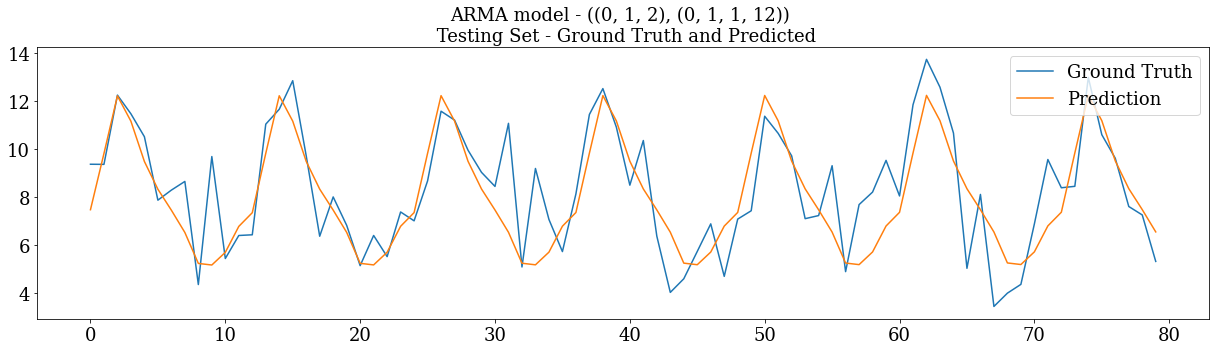

In [15]:
min_params = ((0, 1, 2), (0, 1, 1, 12))
rmse_, aic, bic, min_params = withoutX(min_params)

In [16]:
print("RMSE : ",rmse_," \nAIC : ", aic," \nBIC : ",bic )

RMSE :  1.5579398629430654  
AIC :  2202.6770556753745  
BIC :  2220.8756586443096


In [17]:
print("Best param values are : ((p,d,q),(P,D,Q,S)) : ",min_params)

Best param values are : ((p,d,q),(P,D,Q,S)) :  ((0, 1, 2), (0, 1, 1, 12))


# ARMAX

In [18]:
def withX(sunspot_delay, min_params):
    year_start = 1951 - sunspot_delay
    year_end = 2017 - sunspot_delay
    
    precipitation, sunspot = data(['%s-01-01'%(year_start), '%s-01-01'%(year_end)])

    train = precipitation[:int(0.9*len(precipitation))].copy()
    test = precipitation[int(0.9*len(precipitation)):].copy()

    exog_train = sunspot[:int(0.9*len(sunspot))].copy()
    exog_test = sunspot[int(0.9*len(sunspot)):].copy()
    
    yhat_x,aic,bic = walk_forward(train['Precipitation'], test['Precipitation'], min_params, exog_train['Sunspot'], exog_test['Sunspot'])
    rmse_ = measure_rmse(test['Precipitation'], yhat_x)
    
    plt.figure(figsize=(21,5))
    plt.plot(range(len(test['Precipitation'])),test['Precipitation'],label="Ground Truth")
    plt.plot(range(len(yhat_x)),yhat_x,label="Prediction")
    plt.title("ARMAX model (With Sunspot Data) - ((0, 1, 2), (0, 1, 1, 12)) \n Testing Set - Ground Truth and Predicted")
    plt.savefig('armax.png')
    plt.legend()
    plt.show()
    
    return rmse_, aic, bic, min_params

MLE vals {'fopt': 1.541334849243445, 'gopt': array([ 2.31553221e-05,  1.12591803e-04, -9.75886039e-08, -1.51389612e-04,
       -1.60331748e-06]), 'fcalls': 258, 'warnflag': 0, 'converged': True, 'iterations': 34}


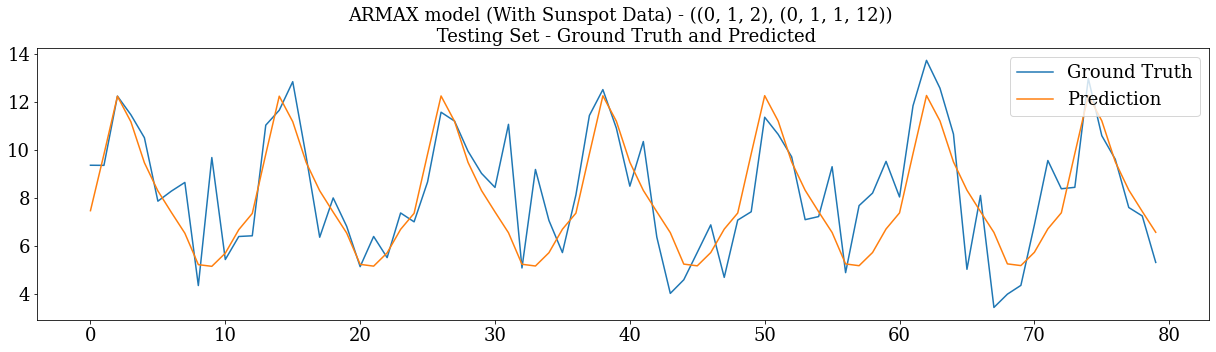

In [19]:
min_params = ((0, 1, 2), (0, 1, 1, 12))
rmse_, aic, bic, min_params = withX(9, min_params)

In [142]:
print("RMSE : ",rmse_," \nAIC : ", aic," \nBIC : ",bic )

RMSE :  1.5585888315108154  
AIC :  2204.8608253226657  
BIC :  2227.609079033835


MLE vals {'fopt': 1.5351775768222669, 'gopt': array([-1.24439126e-05,  4.24325020e-06, -1.10515153e-05,  1.32099442e-05,
        2.77406986e-06,  2.59692268e-06,  5.78315174e-07, -3.03557179e-06,
        3.56217278e-06]), 'fcalls': 410, 'warnflag': 0, 'converged': True, 'iterations': 32}


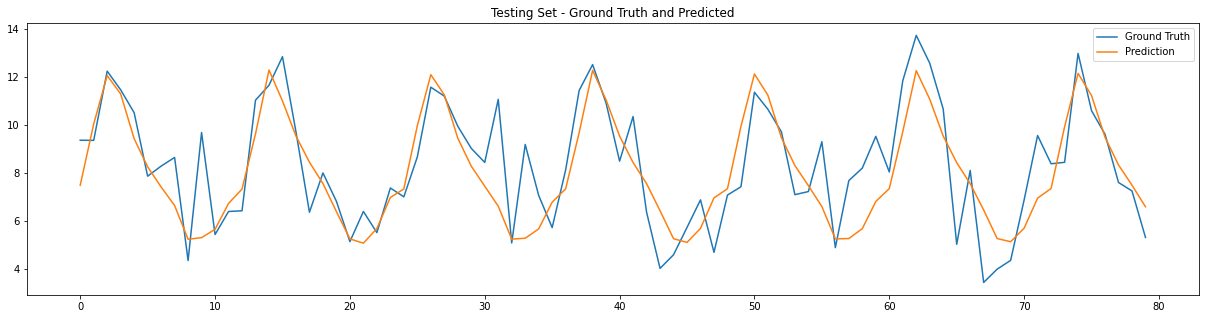

MLE vals {'fopt': 1.535640709029951, 'gopt': array([-6.98221458e-04, -7.93529908e-05,  4.80493645e-05,  2.44803977e-04,
        1.36934841e-04,  7.89450061e-05,  8.33380698e-05, -3.61822927e-04,
        1.49529034e-04,  6.21049434e-05]), 'fcalls': 748, 'warnflag': 0, 'converged': True, 'iterations': 45}


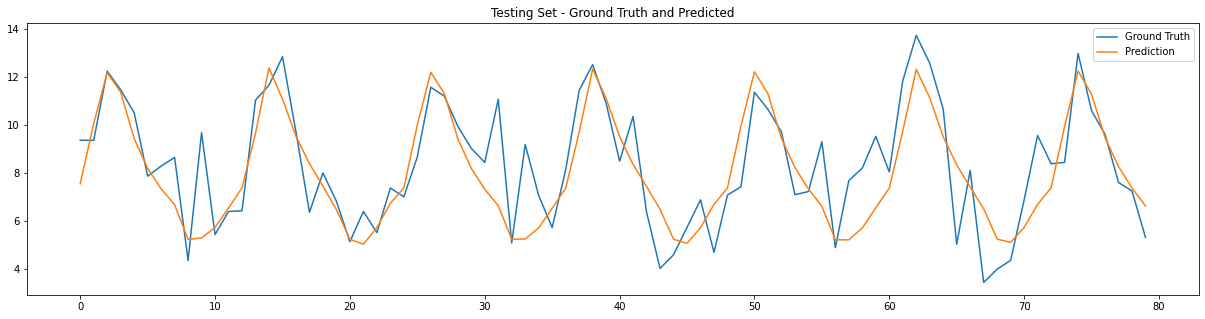

MLE vals {'fopt': 1.5352162456769838, 'gopt': array([-3.93997008e-03,  1.28269395e-05, -1.84075599e-04,  2.70507639e-04,
        2.53526244e-04, -9.22368182e-05, -1.23070376e-04, -4.17276014e-04,
       -2.73061129e-05, -1.89419236e-04]), 'fcalls': 605, 'warnflag': 0, 'converged': True, 'iterations': 44}


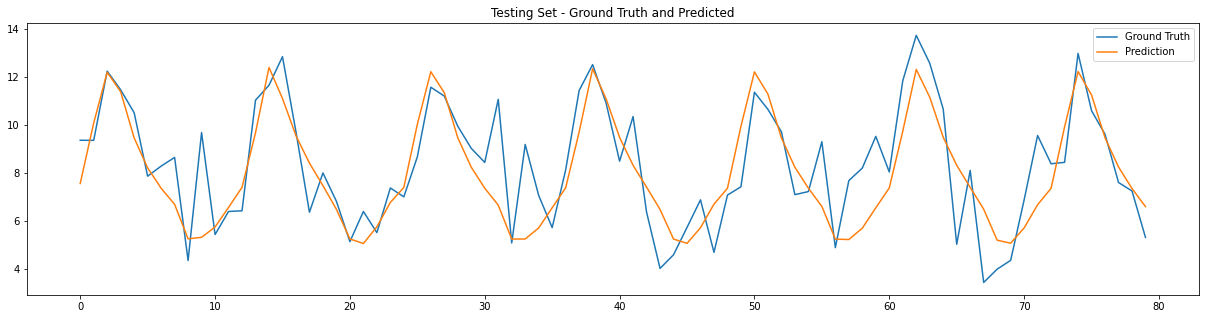

MLE vals {'fopt': 1.5352227906394287, 'gopt': array([-5.51535566e-03,  3.66678021e-05, -3.80873932e-04,  3.14995807e-04,
        3.21619087e-04,  4.82105467e-06,  1.74493686e-04, -4.45389503e-04,
        4.32868852e-05, -2.48671350e-04]), 'fcalls': 1177, 'warnflag': 0, 'converged': True, 'iterations': 82}


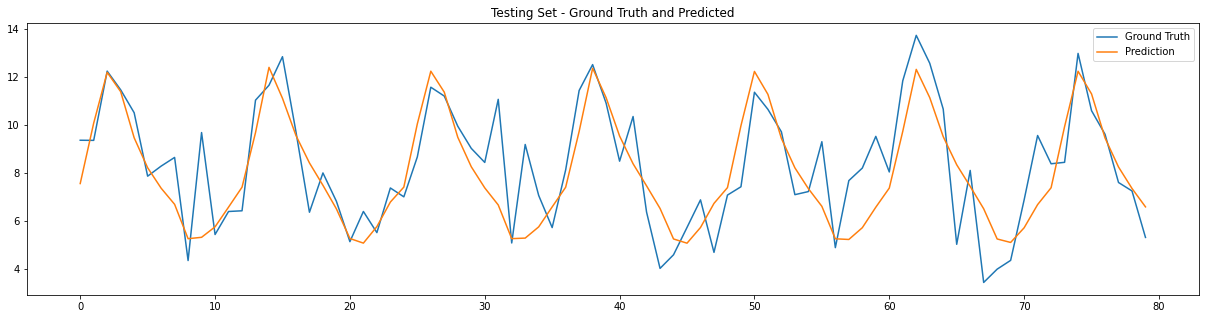

MLE vals {'fopt': 1.5350808965097293, 'gopt': array([ 5.66921268e-03,  6.89241331e-05,  3.90596844e-04,  2.41542342e-06,
        9.00219455e-05,  4.52296423e-05, -8.51015325e-04,  3.94160260e-05,
       -6.60566712e-05,  1.10492415e-04]), 'fcalls': 1232, 'warnflag': 0, 'converged': True, 'iterations': 96}


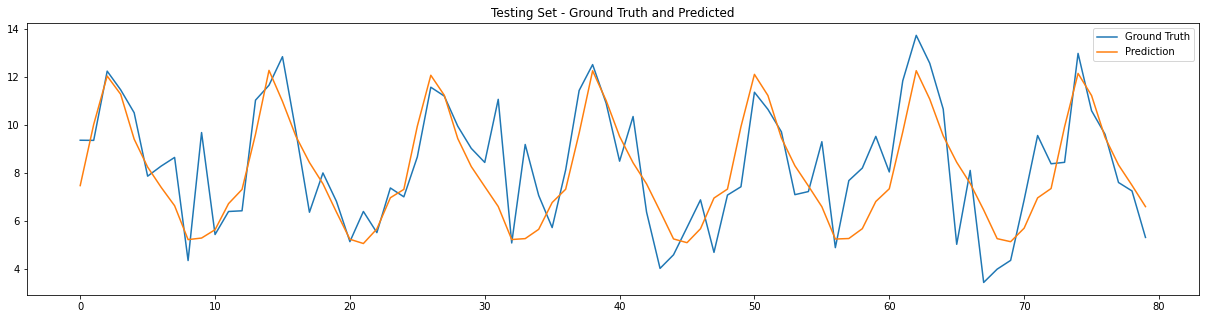

MLE vals {'fopt': 1.534701782979654, 'gopt': array([ 2.19122962e-03,  1.88411953e-05,  4.52450299e-05,  2.01882466e-04,
        2.31822761e-04,  9.16128062e-05, -3.56704000e-05, -2.25856334e-04,
       -3.50380169e-05,  1.28010047e-05]), 'fcalls': 1155, 'warnflag': 0, 'converged': True, 'iterations': 78}


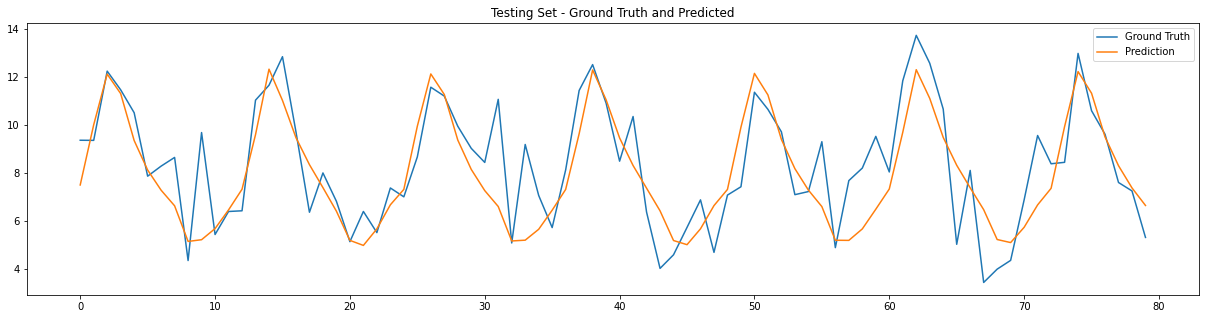

MLE vals {'fopt': 1.5356273332136086, 'gopt': array([ 2.60111530e-03,  4.22267998e-05,  1.15395649e-04,  2.22170793e-04,
        2.03066919e-04,  9.70613367e-05, -1.37547218e-04, -2.68092948e-04,
        1.00844666e-05,  1.94148497e-04]), 'fcalls': 891, 'warnflag': 0, 'converged': True, 'iterations': 70}


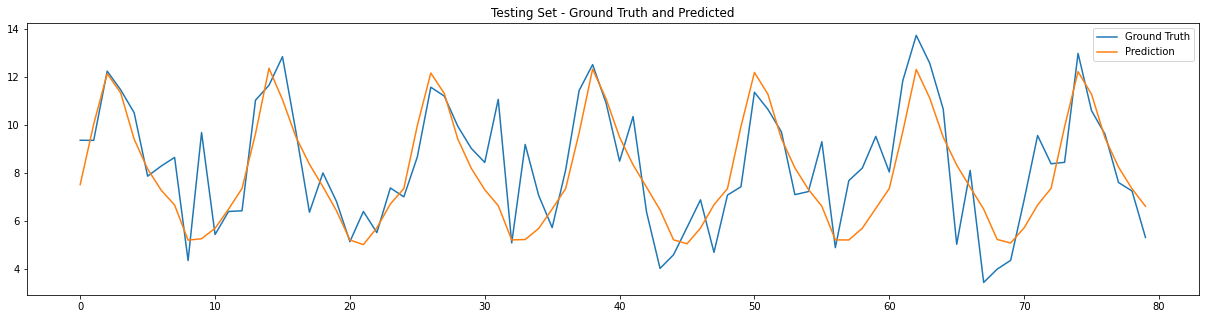

MLE vals {'fopt': 1.5334673785978377, 'gopt': array([ 4.36587582e-03,  1.44468193e-04,  1.58024860e-04,  1.88819138e-04,
        2.50392218e-04,  8.21915647e-05, -5.18407539e-05, -2.13923368e-04,
       -1.41232936e-04,  5.37250244e-05]), 'fcalls': 1166, 'warnflag': 0, 'converged': True, 'iterations': 94}


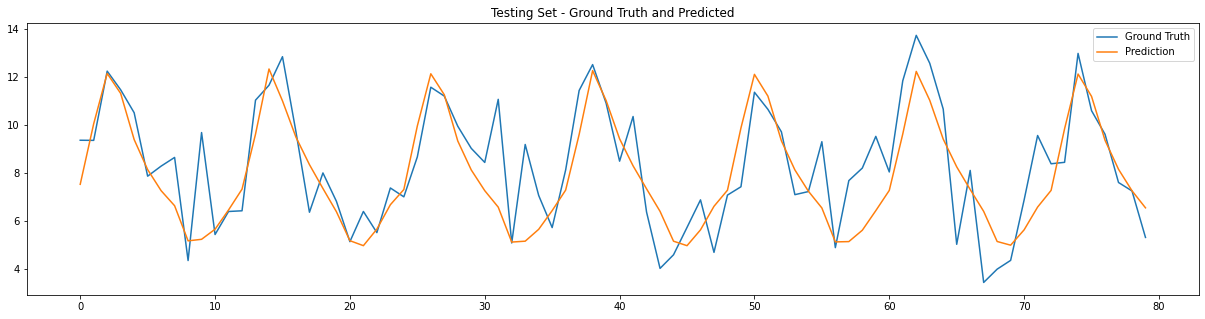

MLE vals {'fopt': 1.5354938347989062, 'gopt': array([ 3.75382052e-03,  1.65246927e-05,  9.32401933e-05,  2.27983987e-04,
        2.52714472e-04,  2.31365815e-05,  1.47813983e-05, -3.38829498e-04,
        1.13751231e-06, -3.81476850e-05]), 'fcalls': 803, 'warnflag': 0, 'converged': True, 'iterations': 62}


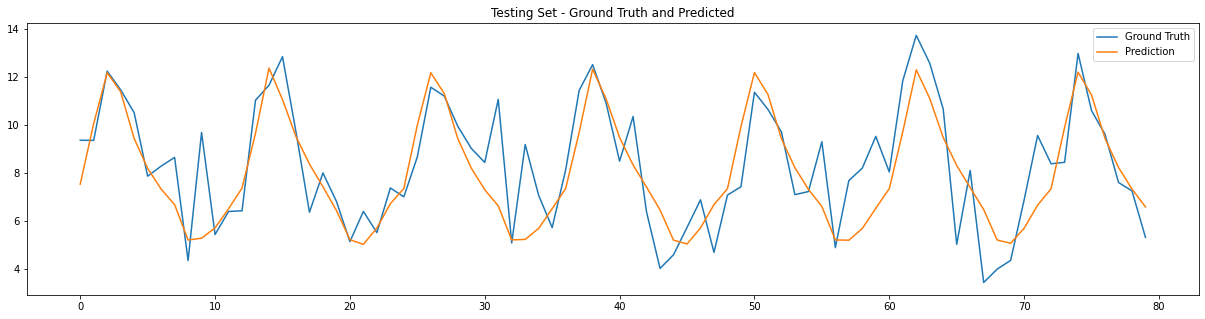

MLE vals {'fopt': 1.535165439124472, 'gopt': array([-1.02643911e-03,  4.83579843e-05, -1.13866889e-03, -8.73443540e-06,
        7.51544382e-05, -1.41130285e-04, -9.12483644e-05,  3.96361388e-05,
       -2.07644635e-04, -3.15950976e-04]), 'fcalls': 1672, 'warnflag': 0, 'converged': True, 'iterations': 123}


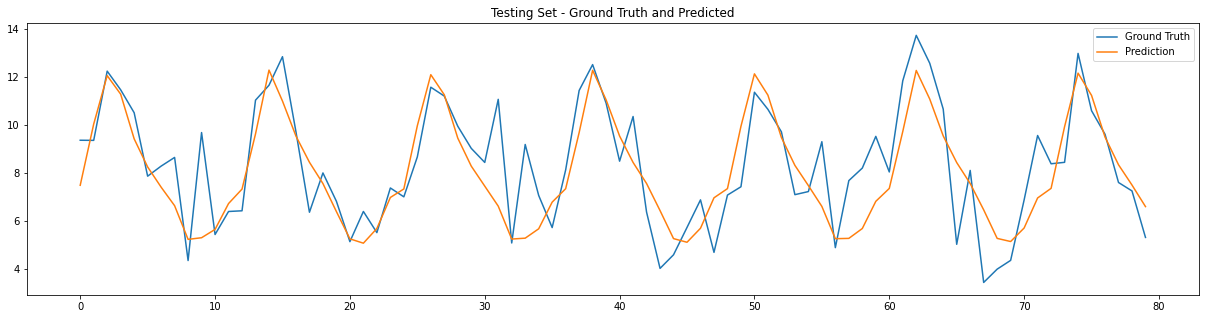

MLE vals {'fopt': 1.535696999163618, 'gopt': array([-2.00071768e-03,  1.03845821e-05,  4.39708381e-04,  2.57713872e-04,
        2.74174194e-04, -1.28302591e-04,  1.97387973e-04, -4.27338476e-04,
       -1.03040199e-04, -5.77027315e-06]), 'fcalls': 737, 'warnflag': 0, 'converged': True, 'iterations': 57}


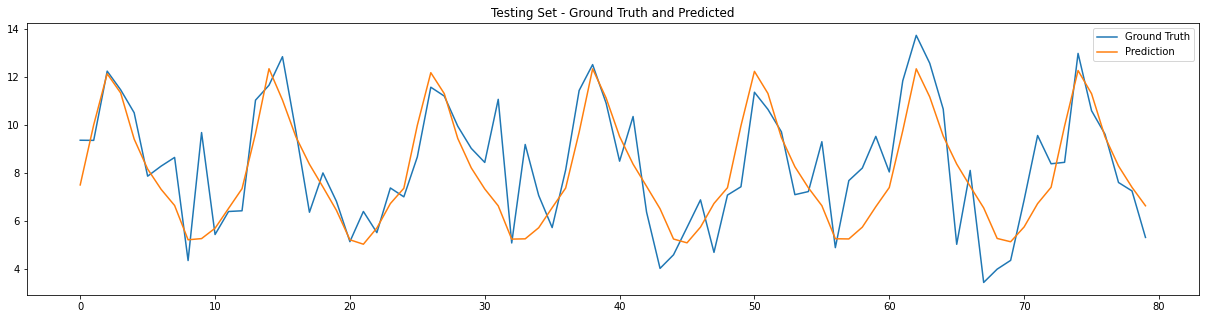

MLE vals {'fopt': 1.533702184432382, 'gopt': array([-4.83817542e-04, -2.97713409e-05, -1.30744526e-05,  2.86859536e-04,
        2.39902298e-04, -6.66661393e-05, -1.83605353e-05, -4.51866677e-04,
        3.80501408e-05, -1.21583188e-05]), 'fcalls': 891, 'warnflag': 0, 'converged': True, 'iterations': 65}


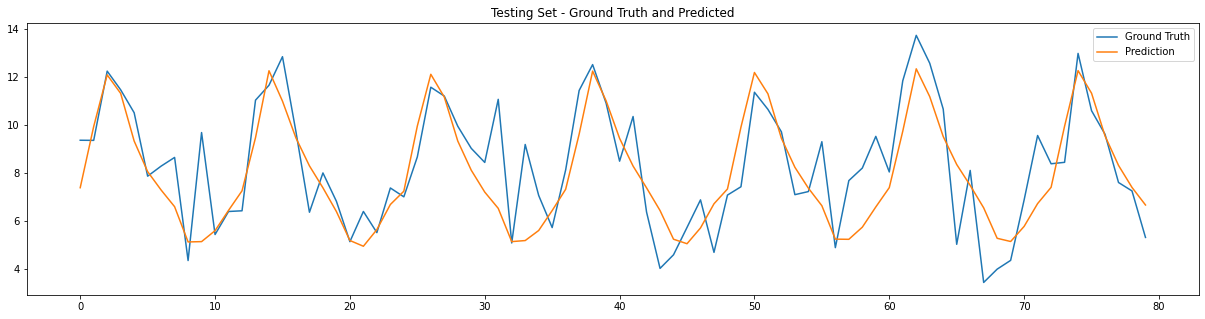

MLE vals {'fopt': 1.5331200311842947, 'gopt': array([ 1.21680443e-08,  1.22257759e-07, -1.66888725e-06,  3.48598927e-06]), 'fcalls': 125, 'warnflag': 0, 'converged': True, 'iterations': 19}


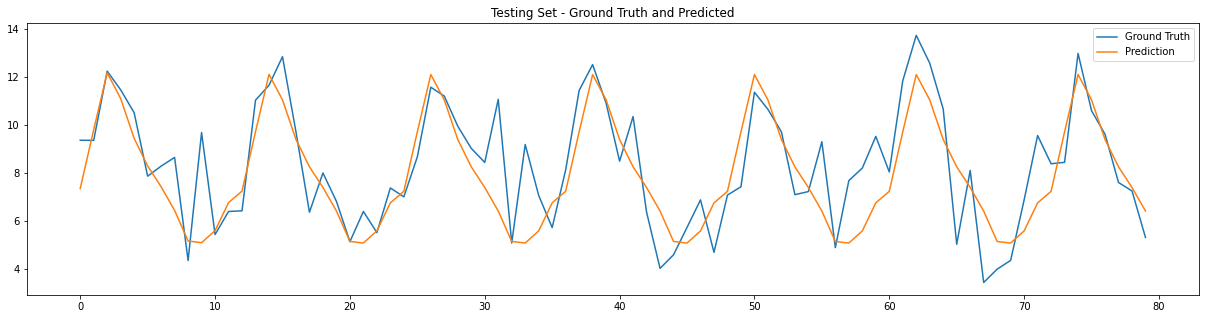

MLE vals {'fopt': 1.5333198740060516, 'gopt': array([-3.20227511e-03,  8.89110408e-04,  7.63879648e-04, -5.47260015e-05,
       -4.46313875e-05]), 'fcalls': 312, 'warnflag': 0, 'converged': True, 'iterations': 38}


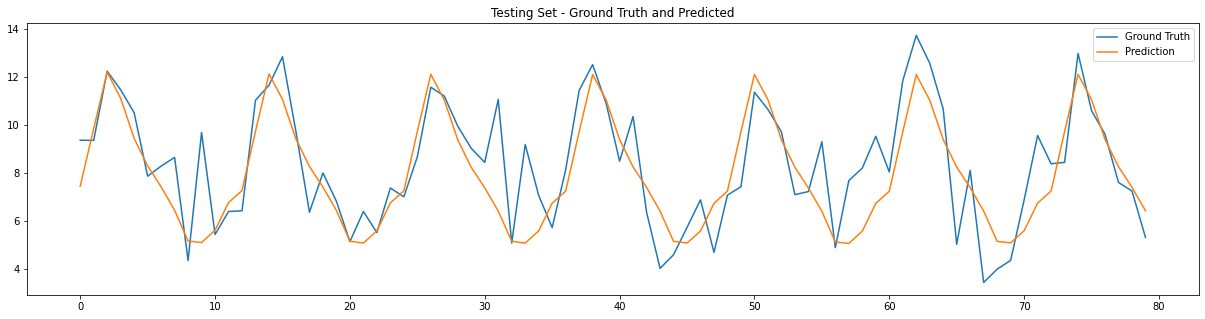

MLE vals {'fopt': 1.5325328731960415, 'gopt': array([ 5.26114707e-06, -6.41708908e-09,  5.10702591e-10, -1.44773082e-08,
        5.23359134e-08]), 'fcalls': 360, 'warnflag': 0, 'converged': True, 'iterations': 42}


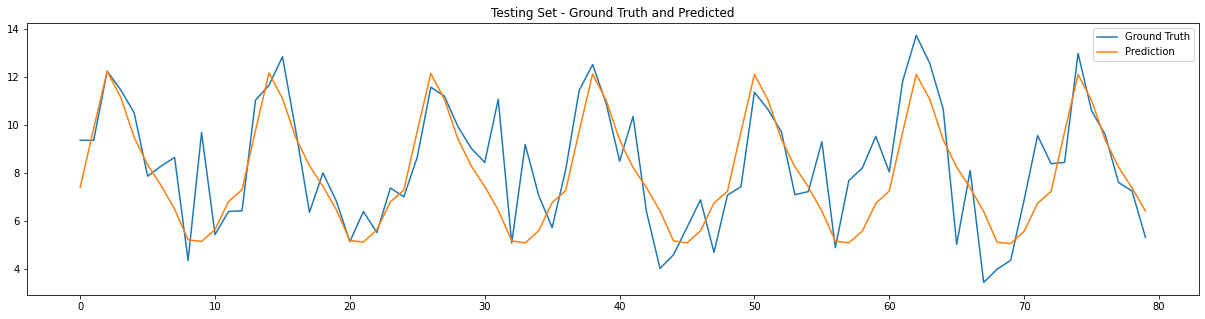

MLE vals {'fopt': 1.5326360582383243, 'gopt': array([-5.28283195e-05, -1.79278814e-07, -6.04671868e-07, -4.17332835e-07,
       -2.37419195e-05]), 'fcalls': 420, 'warnflag': 0, 'converged': True, 'iterations': 49}


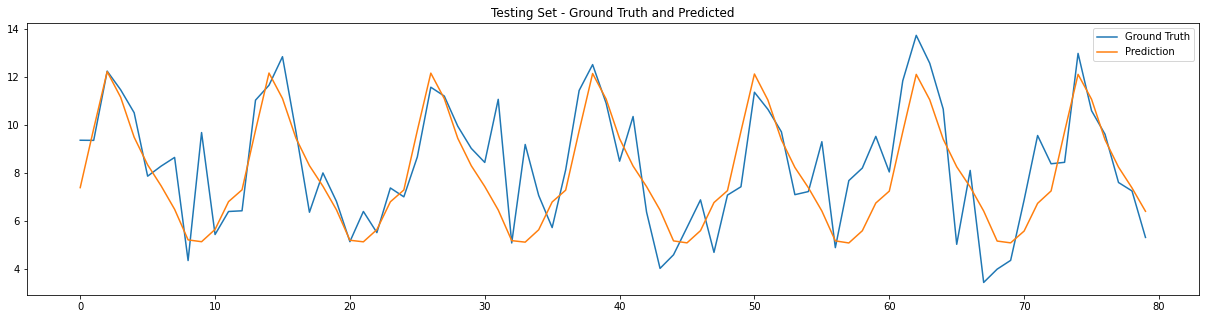

MLE vals {'fopt': 1.533079295149943, 'gopt': array([ 6.63370026e-04,  9.39617273e-06, -1.05088160e-05,  1.00472963e-06,
        1.52686752e-06]), 'fcalls': 390, 'warnflag': 0, 'converged': True, 'iterations': 37}


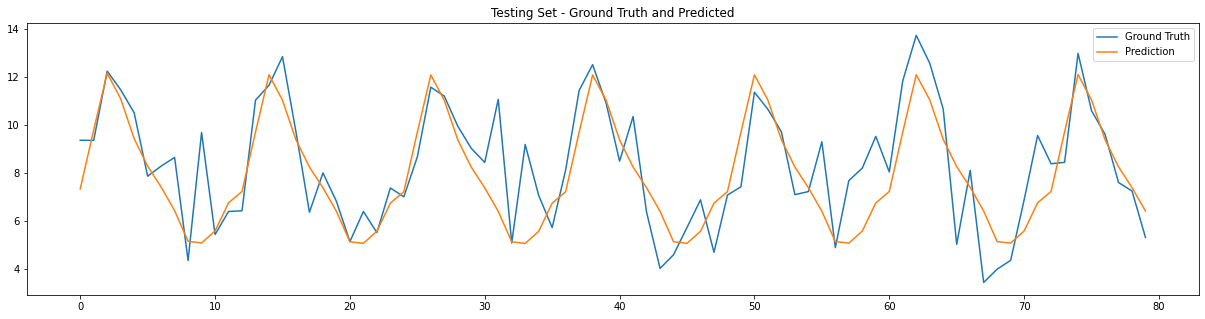

MLE vals {'fopt': 1.5319578763363908, 'gopt': array([ 2.66425282e-04, -9.83837456e-06,  1.23137278e-05, -6.34159392e-08,
        1.28522304e-05]), 'fcalls': 462, 'warnflag': 0, 'converged': True, 'iterations': 60}


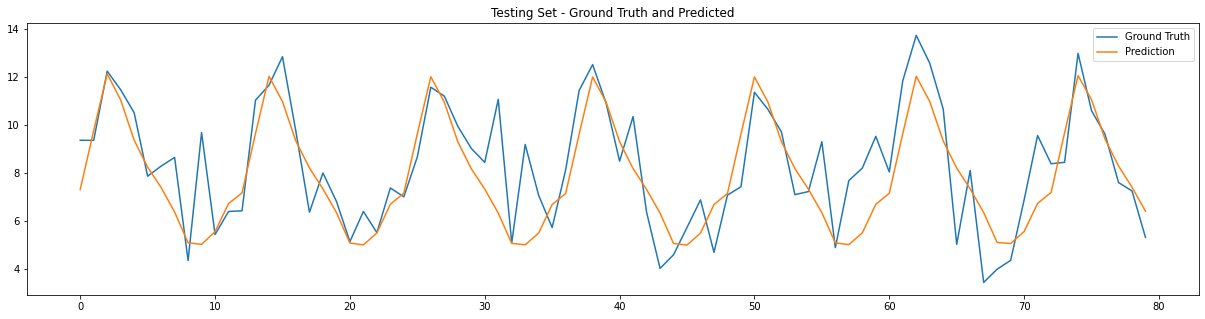

MLE vals {'fopt': 1.5332208203922855, 'gopt': array([ 1.31568474e-03,  5.66287728e-04,  4.24403201e-04, -3.47647910e-05,
       -3.55933727e-05]), 'fcalls': 420, 'warnflag': 0, 'converged': True, 'iterations': 34}


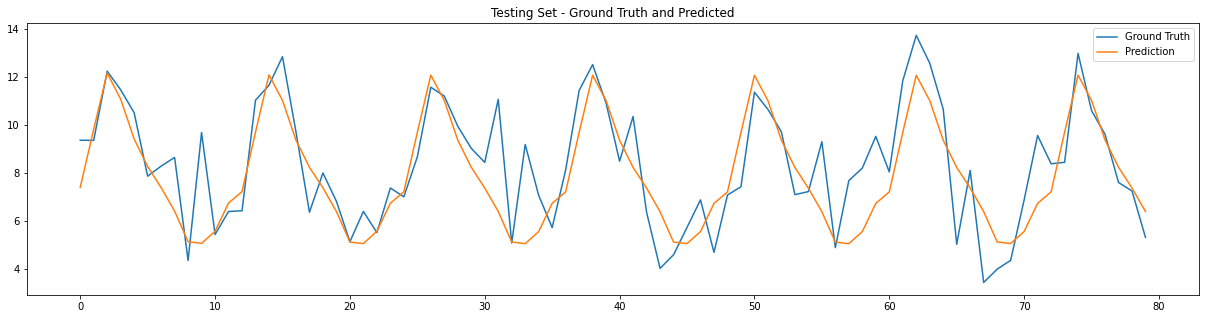

MLE vals {'fopt': 1.5311089499861048, 'gopt': array([ 3.64566355e-04, -6.55799859e-06,  7.43374251e-06, -9.49951229e-07,
       -9.89879290e-06]), 'fcalls': 360, 'warnflag': 0, 'converged': True, 'iterations': 51}


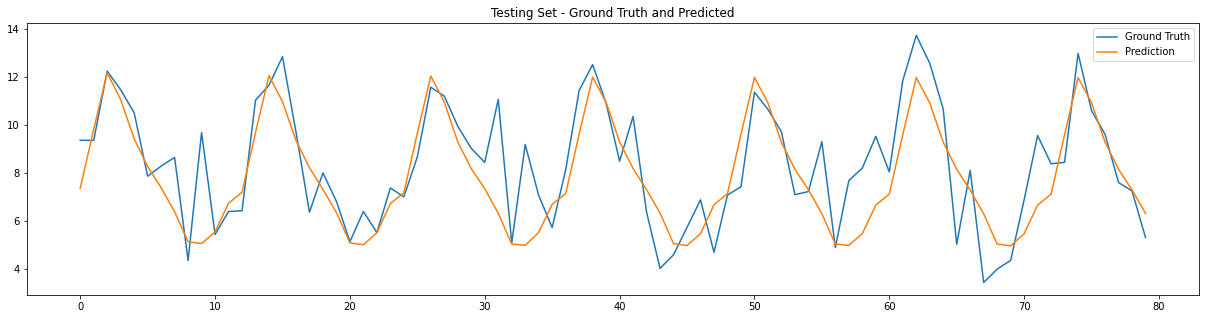

MLE vals {'fopt': 1.532911675203066, 'gopt': array([ 1.36653644e-04, -6.88726409e-05,  7.93539234e-05,  2.49689158e-06,
       -3.53837581e-04]), 'fcalls': 432, 'warnflag': 0, 'converged': True, 'iterations': 47}


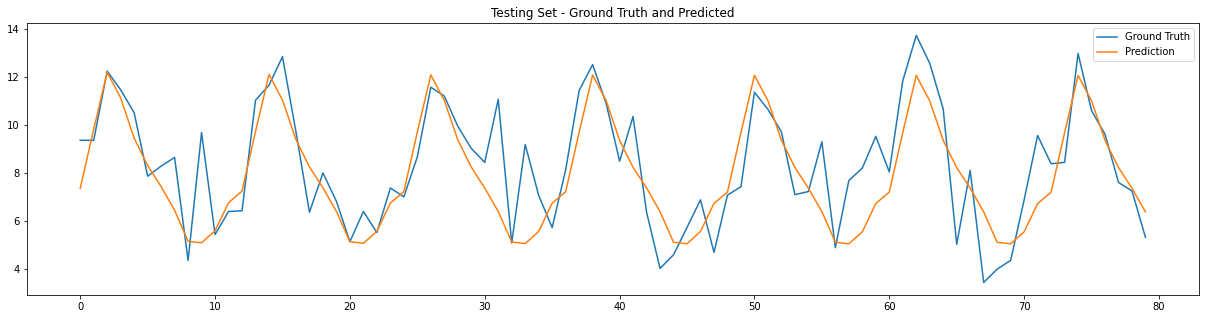

MLE vals {'fopt': 1.5334955579919327, 'gopt': array([-1.29431903e-03,  9.43331635e-04,  7.72040543e-04, -5.65312241e-05,
        5.19339682e-05]), 'fcalls': 276, 'warnflag': 0, 'converged': True, 'iterations': 31}


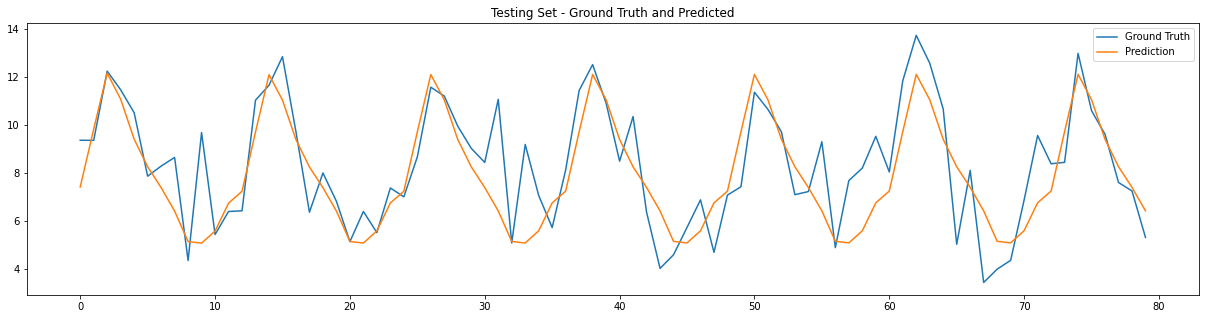

MLE vals {'fopt': 1.5330146560589584, 'gopt': array([-1.87508609e-04,  6.46593890e-08, -2.66164868e-07,  2.61834998e-07,
        6.52338183e-06]), 'fcalls': 498, 'warnflag': 0, 'converged': True, 'iterations': 64}


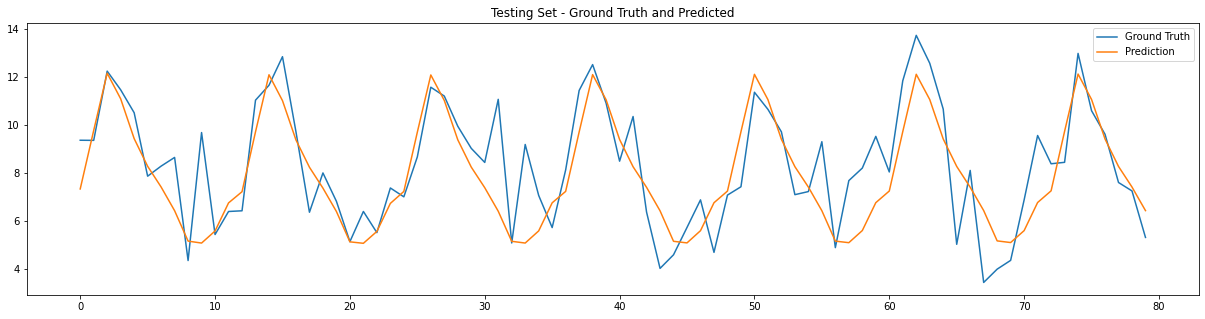

MLE vals {'fopt': 1.5311570691547327, 'gopt': array([-2.03605133e-05, -2.34723352e-07,  2.49200660e-07,  2.94431146e-08,
       -1.12017062e-06]), 'fcalls': 330, 'warnflag': 0, 'converged': True, 'iterations': 45}


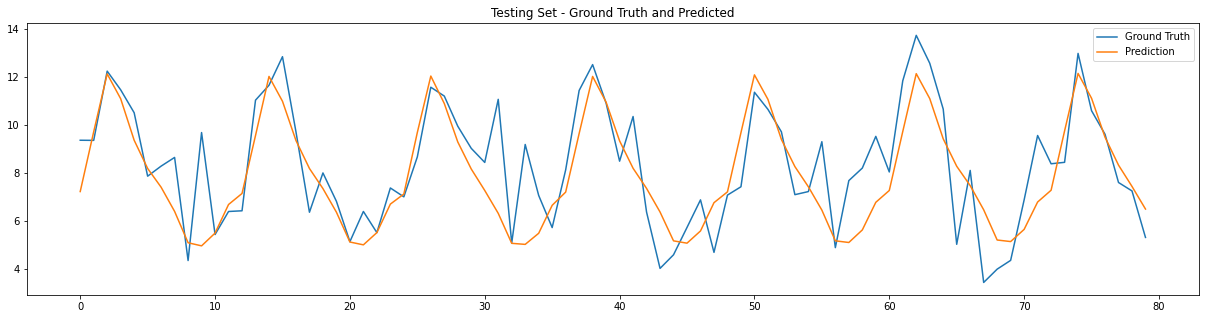

MLE vals {'fopt': 1.5412057975248417, 'gopt': array([ 2.16959783e-06,  7.34368122e-07,  8.22408808e-07, -9.27569133e-06]), 'fcalls': 155, 'warnflag': 0, 'converged': True, 'iterations': 23}


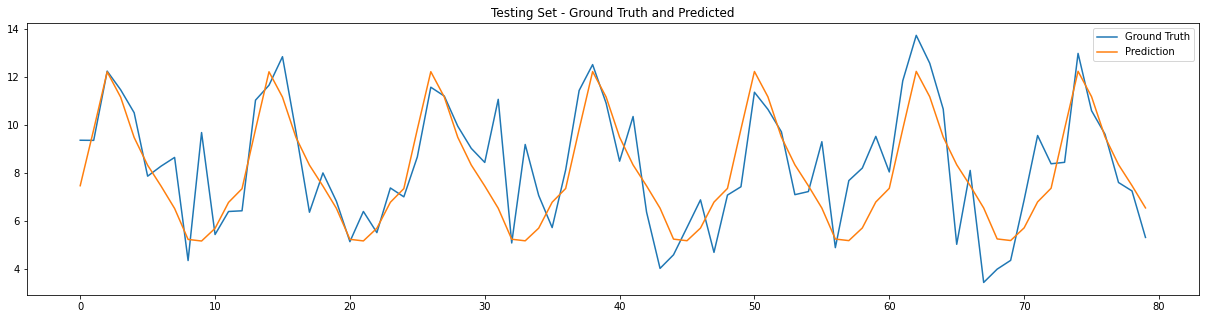

/home/naman_j/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MLE vals {'fopt': 1.541174352232356, 'gopt': array([-1.88464080e-03,  1.16308185e-04, -1.13058451e-06, -1.49130241e-04,
       -1.41271217e-05]), 'fcalls': 402, 'warnflag': 2, 'converged': False, 'iterations': 27}


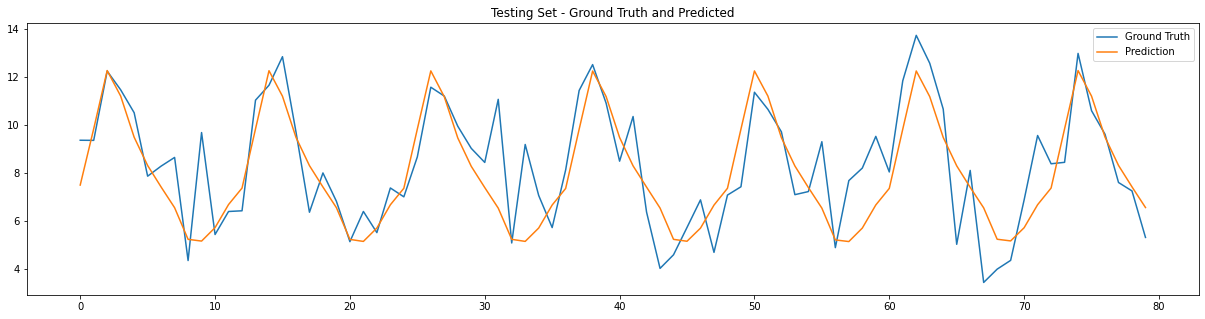

MLE vals {'fopt': 1.540723351988456, 'gopt': array([ 6.19783846e-04,  1.04911990e-04, -1.56344937e-05, -1.51109125e-04,
        1.62958980e-05]), 'fcalls': 228, 'warnflag': 0, 'converged': True, 'iterations': 30}


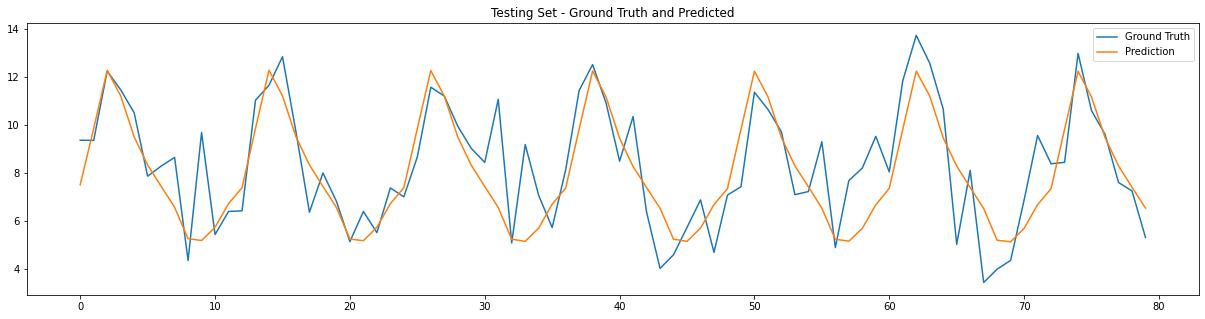

MLE vals {'fopt': 1.5407948168671994, 'gopt': array([-5.94981384e-03,  1.05353370e-04, -1.81002768e-05, -1.40715906e-04,
       -7.29375893e-05]), 'fcalls': 294, 'warnflag': 0, 'converged': True, 'iterations': 33}


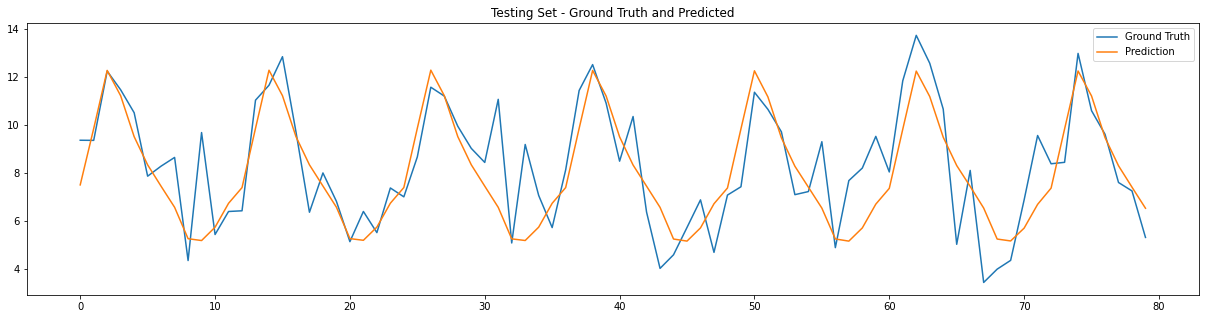

MLE vals {'fopt': 1.5413224881273906, 'gopt': array([ 8.11914602e-04,  1.15699095e-04, -2.47830645e-06, -1.55201940e-04,
        2.20373275e-05]), 'fcalls': 228, 'warnflag': 0, 'converged': True, 'iterations': 24}


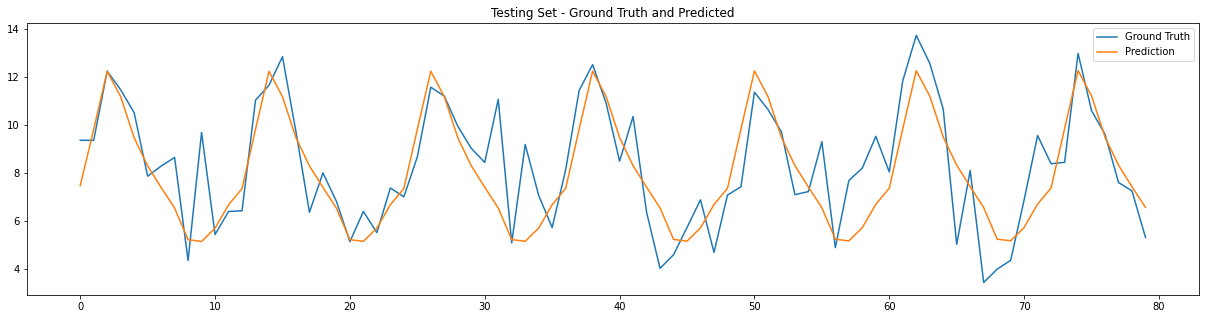

MLE vals {'fopt': 1.5402042288310727, 'gopt': array([ 1.28128248e-03,  1.22920696e-04, -5.85641313e-05, -1.62820979e-04,
       -4.87872187e-05]), 'fcalls': 294, 'warnflag': 0, 'converged': True, 'iterations': 34}


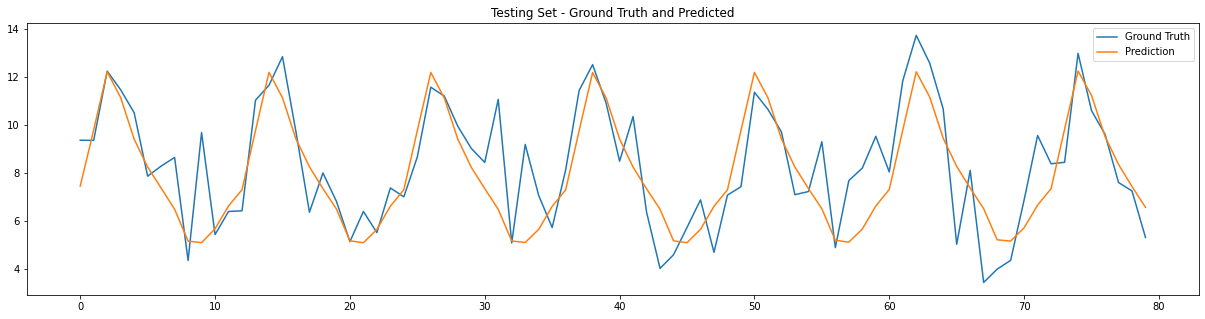

MLE vals {'fopt': 1.5412744203660744, 'gopt': array([ 2.80950336e-03,  1.05783560e-04, -2.56206167e-06, -1.07176135e-04,
       -3.84337007e-06]), 'fcalls': 234, 'warnflag': 0, 'converged': True, 'iterations': 35}


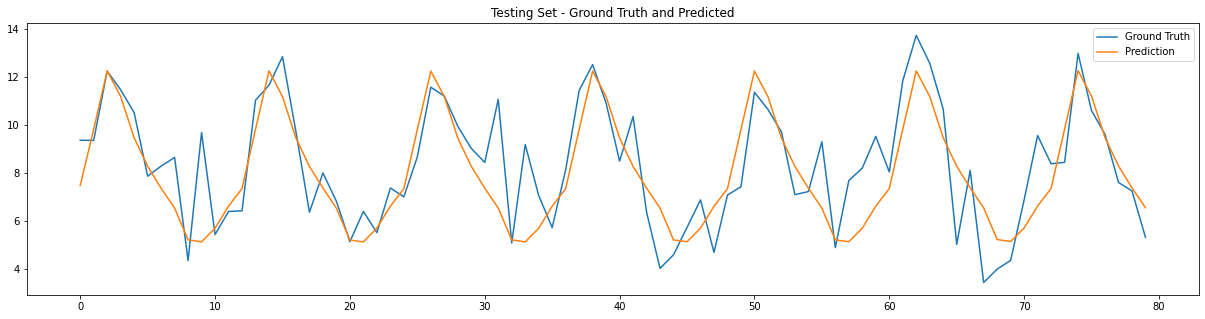

MLE vals {'fopt': 1.5390209460245245, 'gopt': array([ 7.13228743e-04,  1.27899935e-04,  3.65493635e-05, -1.58591540e-04,
        2.14723794e-06]), 'fcalls': 228, 'warnflag': 0, 'converged': True, 'iterations': 29}


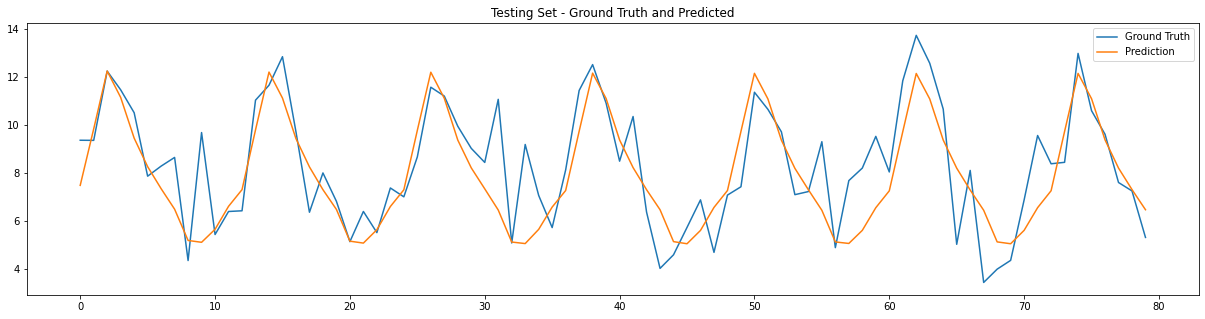

MLE vals {'fopt': 1.5410497211856293, 'gopt': array([ 1.04584919e-04,  1.19437193e-04, -1.26247901e-06, -1.58607905e-04,
        8.63087379e-07]), 'fcalls': 222, 'warnflag': 0, 'converged': True, 'iterations': 30}


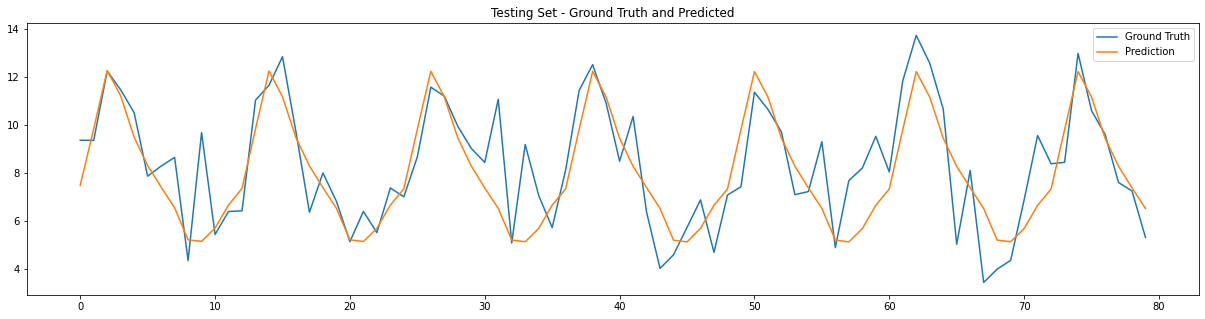

MLE vals {'fopt': 1.541334849243445, 'gopt': array([ 2.31553221e-05,  1.12591803e-04, -9.75886039e-08, -1.51389612e-04,
       -1.60331748e-06]), 'fcalls': 258, 'warnflag': 0, 'converged': True, 'iterations': 34}


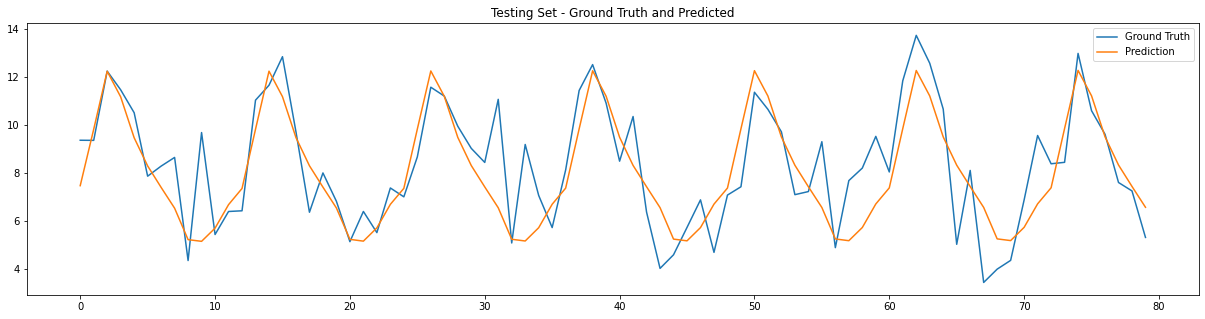

MLE vals {'fopt': 1.541213413123948, 'gopt': array([-8.81466322e-04,  1.15922472e-04,  3.62039287e-06, -1.52667812e-04,
        3.23021609e-06]), 'fcalls': 228, 'warnflag': 0, 'converged': True, 'iterations': 29}


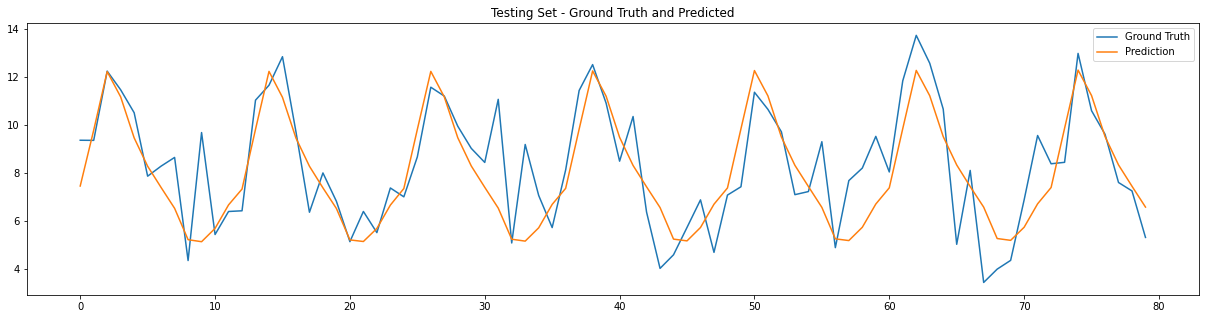

MLE vals {'fopt': 1.5392977608177743, 'gopt': array([ 1.25965305e-04,  1.23404664e-04, -1.01629150e-05, -1.60376534e-04,
        1.89934291e-05]), 'fcalls': 270, 'warnflag': 0, 'converged': True, 'iterations': 29}


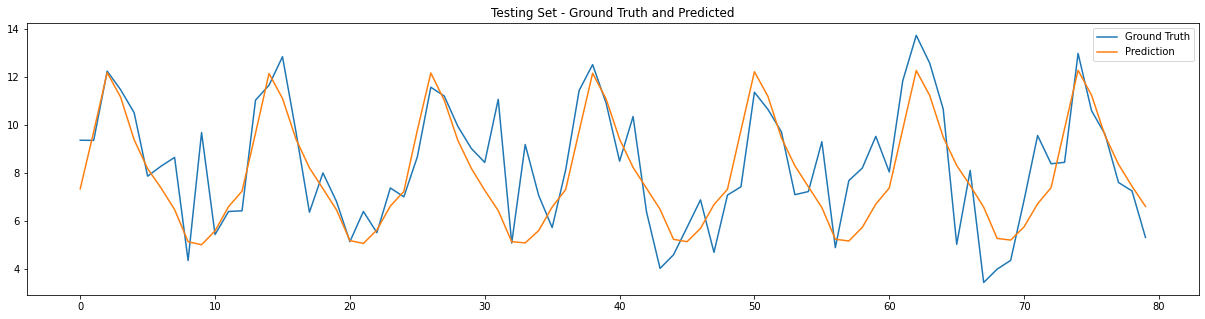

In [152]:
min_params_list = [((2, 1, 2), (2, 1, 2, 12)), ((1, 0, 1), (0, 1, 1, 12)), ((0, 1, 2), (0, 1, 1, 12))]
results = {}

for ind, min_params in enumerate(min_params_list):
    results[ind] = {}
    results[ind]['withoutX'] = withoutX(min_params)
    for delay in range(1,12):
        results[ind][delay] = withX(delay, min_params)

In [155]:
df = pd.DataFrame(results)

In [158]:
df.to_csv('results_ARMAX_ARMA.csv')

In [160]:
for ind in results:
    for d in results[ind]:
        results[ind][d] = {'rmse':results[ind][d][0],'aic':results[ind][d][1],'bic':results[ind][d][2]}

In [163]:
df = pd.DataFrame(results)

In [167]:
df.reset_index(inplace=True)

In [172]:
a = pd.concat([df.drop(0, axis=1), pd.DataFrame(df[0].tolist())], axis=1)
b = pd.concat([a.drop(1, axis=1), pd.DataFrame(a[1].tolist())], axis=1)
c = pd.concat([b.drop(2, axis=1), pd.DataFrame(b[2].tolist())], axis=1)

In [180]:
c

,index,rmse,aic,bic,rmse,aic,bic,rmse,aic,bic
0,withoutX,1.555927,2204.092869,2245.039726,1.578595,2191.162924,2209.367246,1.557940,2202.677056,2220.875659
1,1,1.560709,2206.752370,2252.248877,1.578519,2193.447501,2216.202902,1.561144,2204.632278,2227.380531
2,2,1.556083,2206.147934,2251.644441,1.571512,2192.326811,2215.082213,1.556172,2203.990053,2226.738307
3,3,1.555618,2206.157254,2251.653761,1.571800,2192.473747,2215.229149,1.555774,2204.091819,2226.840073
4,4,1.558328,2205.955197,2251.451704,1.581490,2193.104916,2215.860318,1.560295,2204.843223,2227.591477
5,5,1.570863,2205.415339,2250.911846,1.597997,2191.508016,2214.263418,1.571670,2203.250822,2225.999076
6,6,1.563448,2206.733322,2252.229830,1.584106,2193.306448,2216.061850,1.564433,2204.774775,2227.523028
7,7,1.577077,2203.657547,2249.154055,1.600798,2190.299145,2213.054546,1.578313,2201.565827,2224.314081
8,8,1.561995,2206.543221,2252.039728,1.582670,2192.866225,2215.621627,1.562652,2204.454803,2227.203057
9,9,1.555764,2206.075585,2251.572093,1.578467,2193.697675,2216.453076,1.558589,2204.860825,2227.609079
